In [1]:
pip install pandas==1.5.3

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_1441/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [1]:
import os
import sys

##get current file directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
##get the parent directory
parent_dir = os.path.dirname(current_dir)
# Add the src directory to sys.path
src_dir = os.path.join(parent_dir, '../')
sys.path.append(src_dir)

from algorithm.calculo_entropia import *
import algorithm.calculo_entropia

from algorithm.coarsening_utils import *
import algorithm.graph_utils
import algorithm.coarsening_utils as cu
from algorithm.coarsening_utils import plot_coarsening_vertical

import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import networkx as nx
import pygsp as gsp
from pygsp import graphs
gsp.plotting.BACKEND = 'matplotlib'

import pickle

def save_graphs(graph_dict, filename):
    """
    Save the dictionary of graphs to a file.
    """
    # Convert PyGSP graphs to NetworkX graphs for easier serialization
    nx_graph_dict = {
        size: [nx.from_scipy_sparse_array(g.W) for g in graphs]
        for size, graphs in graph_dict.items()
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(nx_graph_dict, f)
    print(f"Graphs saved to {filename}")

def load_graphs(filename):
    """
    Load the dictionary of graphs from a file.
    """
    with open(filename, 'rb') as f:
        nx_graph_dict = pickle.load(f)
    print(f"Graphs loaded from {filename}")
    return nx_graph_dict

In [4]:
import pandas as pd
print(pd.__version__)

1.5.3


In [ ]:
import pickle  
# load the data 
infile = open('./CommunityFitNet_updated.pickle','rb')  
df = pickle.load(infile) 

In [3]:
# read edge lists for all networks
df_edgelists = df['edges_id'] # column 'edges_id' in dataframe df includes the edge list 
                              # for each network 
 
# extract the edge list for the first network 
edges_orig = df_edgelists.iloc[0] # a numpy array of edge list for original graph 


## Informacion de los grafos

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# After loading your df:
print(df.head())  # See first few rows
print(df.columns)  # See what columns we have
print(df.info()) 

   network_index                                       network_name  \
0              0  Aishihik_Lake_host-parasite_web_Aishihik_Lake_...   
1              1            Arroyo_plant-pollinator_web_Elevation_1   
2              2            Arroyo_plant-pollinator_web_Elevation_2   
3              3            Arroyo_plant-pollinator_web_Elevation_3   
4              4  Barrett_Helenurm_plant-pollinator_web_Barrett_...   

                                     title  \
0          Aishihik Lake host-parasite web   
1              Arroyo plant-pollinator web   
2              Arroyo plant-pollinator web   
3              Arroyo plant-pollinator web   
4  Barrett & Helenurm plant-pollinator web   

                                         description networkDomain subDomain  \
0  A network of parasites and their host species,...    Biological  Food web   
1  A bipartite network of plants and pollinators ...    Biological  Food web   
2  A bipartite network of plants and pollinators ...    

In [5]:
print("Dimensiones del dataset:", df.shape)
print("\nTipos de redes en el dataset:")
domain_counts = df['networkDomain'].value_counts()
print(domain_counts)
print("\nPorcentaje de cada tipo de red:")
print((domain_counts / len(df) * 100).round(2))

# 2. Estadísticas por dominio de red
print("\nEstadísticas por dominio de red:")
for domain in df['networkDomain'].unique():
    domain_df = df[df['networkDomain'] == domain]
    print(f"\n{domain} Networks ({len(domain_df)} grafos):")
    
    # Estadísticas básicas de nodos y aristas
    stats = domain_df[['number_nodes', 'number_edges', 'ave_degree']].describe()
    print(stats)
    
    # Propiedades de los grafos
    print("\nPropiedades de los grafos:")
    print(domain_df['graphProperties'].value_counts())
    
    # Subdominios
    print("\nSubdominios:")
    print(domain_df['subDomain'].value_counts())

# 3. Mostrar los 10 grafos más grandes (por número de nodos)
print("\nLos 10 grafos más grandes (por número de nodos):")
print(df.sort_values('number_nodes', ascending=False)[['network_name', 'networkDomain', 'number_nodes', 'number_edges', 'ave_degree']].head(10))

# 4. Mostrar los 10 grafos más densos (por grado promedio)
print("\nLos 10 grafos más densos (por grado promedio):")
print(df.sort_values('ave_degree', ascending=False)[['network_name', 'networkDomain', 'number_nodes', 'number_edges', 'ave_degree']].head(10))

# 5. Estadísticas generales para todos los grafos
print("\nEstadísticas generales para todos los grafos:")
print(df[['number_nodes', 'number_edges', 'ave_degree']].describe())

# 6. Contar tipos de propiedades de grafos
print("\nTipos de propiedades de grafos:")
props = pd.Series(', '.join(df['graphProperties']).split(', ')).value_counts()
print(props)

# 7. Análisis de subdominios
print("\nSubdominios por dominio principal:")
for domain in df['networkDomain'].unique():
    print(f"\n{domain}:")
    print(df[df['networkDomain'] == domain]['subDomain'].value_counts())

Dimensiones del dataset: (572, 50)

Tipos de redes en el dataset:
Biological        192
Social            124
Economic          122
Technological      74
Transportation     38
Informational      22
Name: networkDomain, dtype: int64

Porcentaje de cada tipo de red:
Biological        33.57
Social            21.68
Economic          21.33
Technological     12.94
Transportation     6.64
Informational      3.85
Name: networkDomain, dtype: float64

Estadísticas por dominio de red:

Biological Networks (192 grafos):
       number_nodes  number_edges  ave_degree
count    192.000000    192.000000  192.000000
mean     276.411458    729.515625    6.016216
std      384.395524   1015.208162    6.402932
min        5.000000      4.000000    1.600000
25%       65.000000    118.750000    2.542002
50%      116.500000    311.500000    4.191679
75%      319.000000    941.000000    5.463571
max     3155.000000   7562.000000   50.922559

Propiedades de los grafos:
Undirected, Unweighted                      

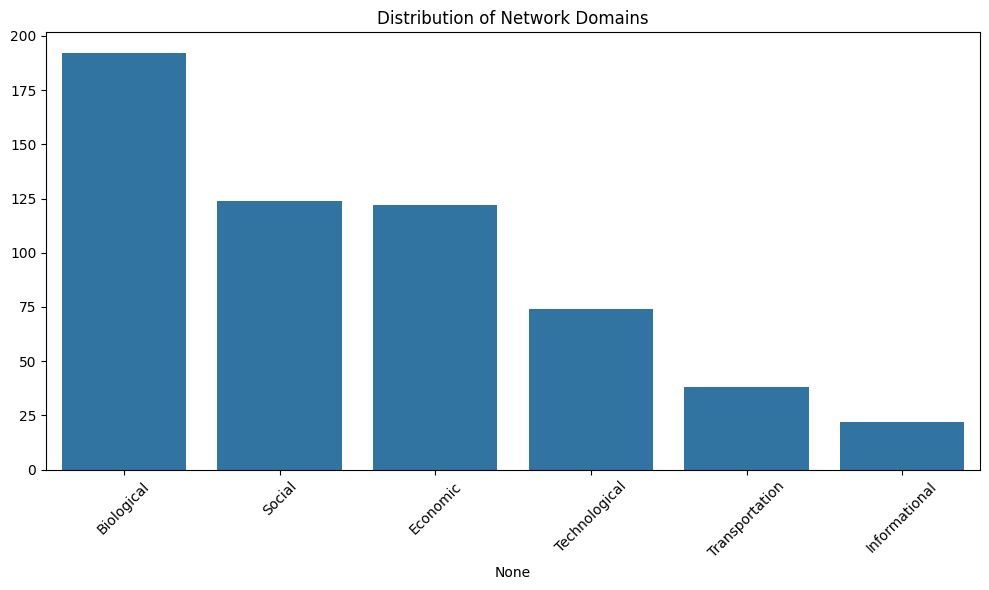

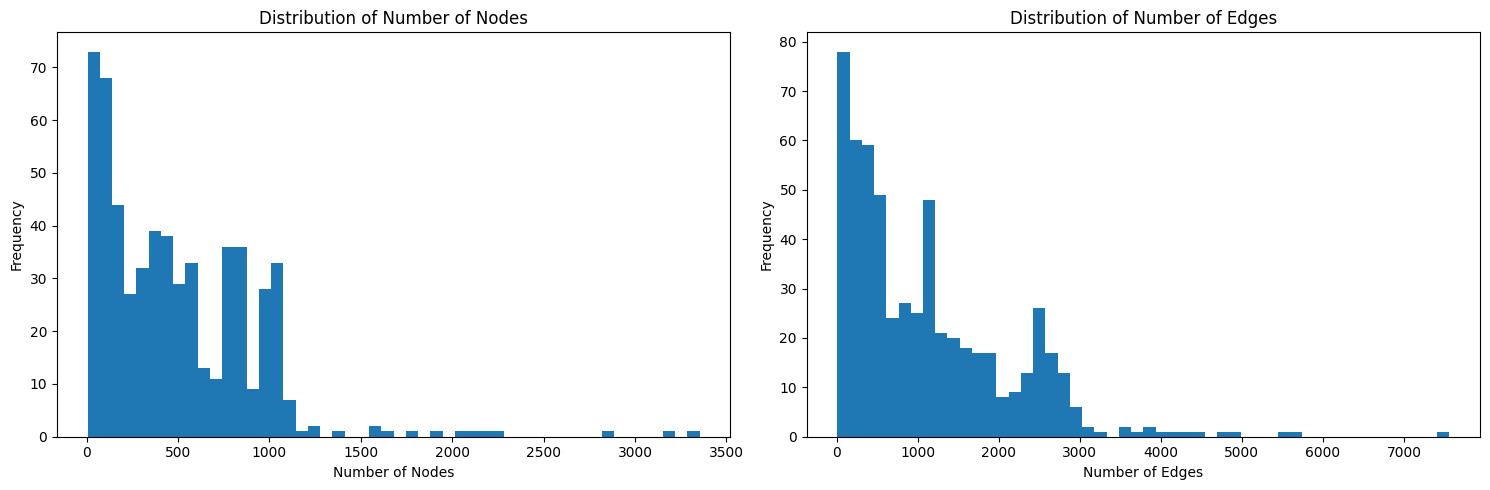

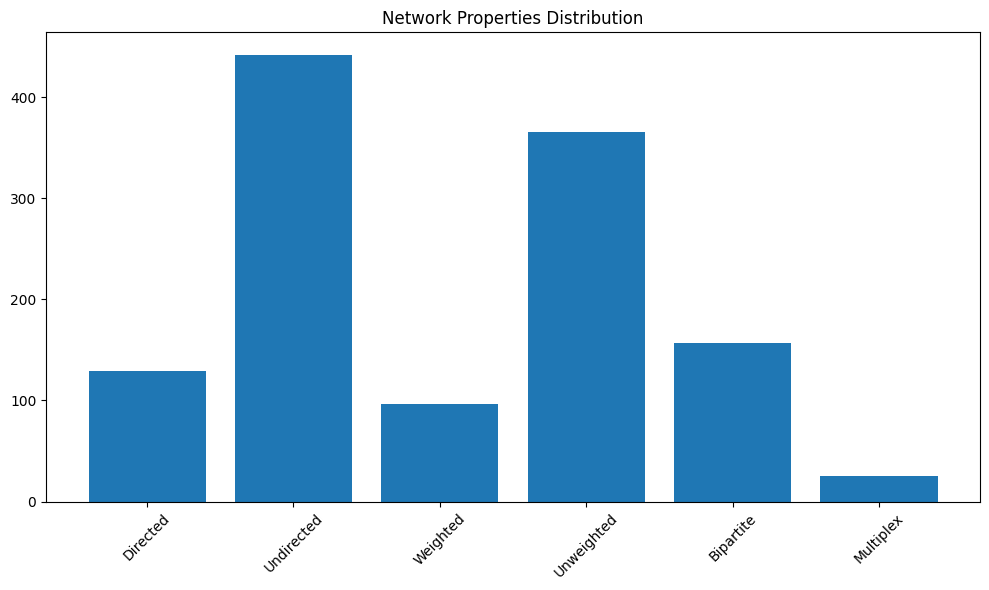

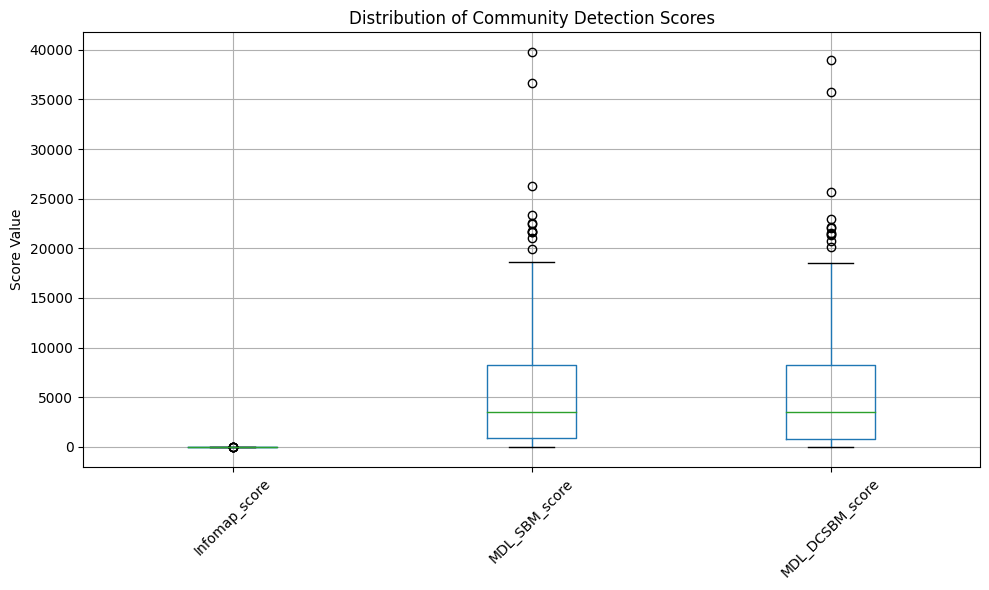

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of network domains
plt.figure(figsize=(10, 6))
domain_counts = df['networkDomain'].value_counts()
sns.barplot(x=domain_counts.index, y=domain_counts.values)
plt.title('Distribution of Network Domains')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Network sizes distribution
plt.figure(figsize=(15, 5))

# Create two subplots
plt.subplot(1, 2, 1)
plt.hist(df['number_nodes'], bins=50)
plt.title('Distribution of Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['number_edges'], bins=50)
plt.title('Distribution of Number of Edges')
plt.xlabel('Number of Edges')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3. Network properties analysis
def analyze_properties(properties_column):
    properties_dict = {
        'Directed': 0,
        'Undirected': 0,
        'Weighted': 0,
        'Unweighted': 0,
        'Bipartite': 0,
        'Multiplex': 0
    }
    
    for props in properties_column:
        for prop in props.split(', '):
            if prop in properties_dict:
                properties_dict[prop] += 1
    
    return properties_dict

props_dict = analyze_properties(df['graphProperties'])
plt.figure(figsize=(10, 6))
plt.bar(props_dict.keys(), props_dict.values())
plt.title('Network Properties Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Comparison of community detection scores
# Converting score columns to numeric, handling 'not updated' and 'n/a'
def convert_to_numeric(column):
    return pd.to_numeric(df[column].replace(['not updated', 'n/a'], None), errors='coerce')

score_columns = ['Infomap_score', 'MDL_SBM_score', 'MDL_DCSBM_score']
scores_data = pd.DataFrame()

for col in score_columns:
    scores_data[col] = convert_to_numeric(col)

plt.figure(figsize=(10, 6))
scores_data.boxplot()
plt.title('Distribution of Community Detection Scores')
plt.xticks(rotation=45)
plt.ylabel('Score Value')
plt.tight_layout()
plt.show()

Total graphs: 572

Direction properties:
Directed: 129
Undirected: 442
Unspecified direction: 1

Weight properties:
Weighted: 97
Unweighted: 366
Unspecified weight: 109

Structure properties:
Bipartite: 157
Multiplex: 25
Unspecified structure: 390


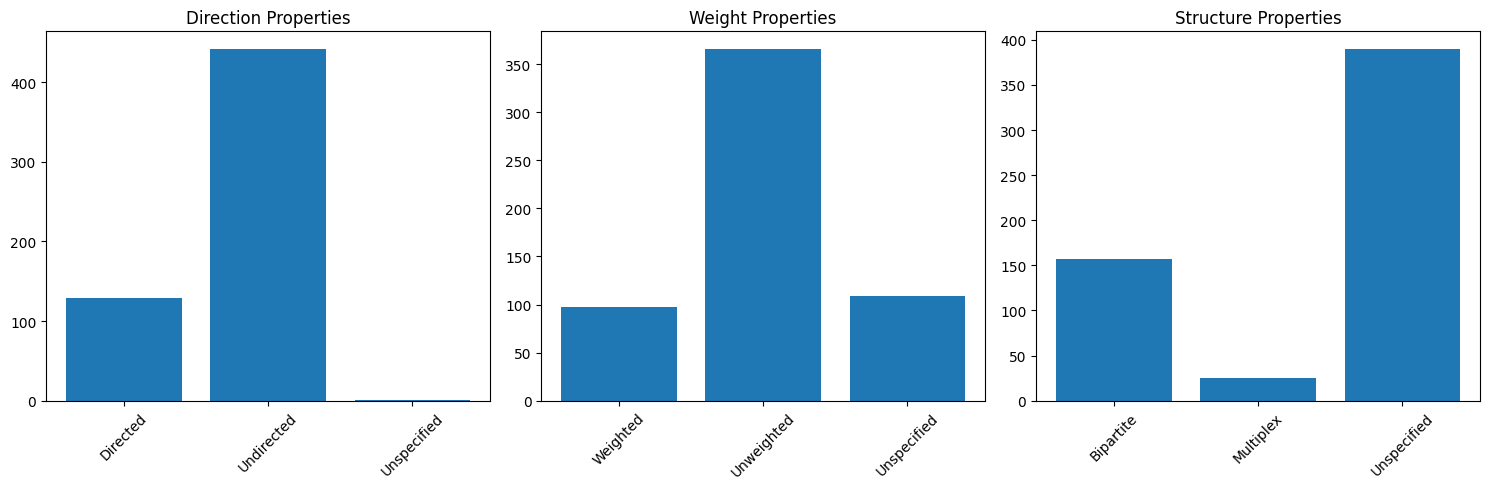

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_graph_completeness(df):
    total_graphs = len(df)
    
    # Count directedness properties
    directed = sum(df['graphProperties'].str.contains('Directed'))
    undirected = sum(df['graphProperties'].str.contains('Undirected'))
    no_direction = total_graphs - (directed + undirected)
    
    # Count weight properties
    weighted = sum(df['graphProperties'].str.contains('Weighted'))
    unweighted = sum(df['graphProperties'].str.contains('Unweighted'))
    no_weight = total_graphs - (weighted + unweighted)
    
    # Count structure properties
    bipartite = sum(df['graphProperties'].str.contains('Bipartite'))
    multiplex = sum(df['graphProperties'].str.contains('Multiplex'))
    no_structure = total_graphs - (bipartite + multiplex)
    
    print(f"Total graphs: {total_graphs}\n")
    print("Direction properties:")
    print(f"Directed: {directed}")
    print(f"Undirected: {undirected}")
    print(f"Unspecified direction: {no_direction}\n")
    
    print("Weight properties:")
    print(f"Weighted: {weighted}")
    print(f"Unweighted: {unweighted}")
    print(f"Unspecified weight: {no_weight}\n")
    
    print("Structure properties:")
    print(f"Bipartite: {bipartite}")
    print(f"Multiplex: {multiplex}")
    print(f"Unspecified structure: {no_structure}")
    
    # Create a more detailed visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Direction plot
    ax1.bar(['Directed', 'Undirected', 'Unspecified'], 
            [directed, undirected, no_direction])
    ax1.set_title('Direction Properties')
    ax1.tick_params(axis='x', rotation=45)
    
    # Weight plot
    ax2.bar(['Weighted', 'Unweighted', 'Unspecified'], 
            [weighted, unweighted, no_weight])
    ax2.set_title('Weight Properties')
    ax2.tick_params(axis='x', rotation=45)
    
    # Structure plot
    ax3.bar(['Bipartite', 'Multiplex', 'Unspecified'], 
            [bipartite, multiplex, no_structure])
    ax3.set_title('Structure Properties')
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_graph_completeness(df)

In [6]:
# Sort within each domain by number of nodes and get top 10
top_networks = []
for domain in df['networkDomain'].unique():
    domain_networks = df[df['networkDomain'] == domain]
    top_10 = domain_networks.nlargest(10, 'number_nodes')
    top_networks.append(top_10)

# Combine all top networks
result_df = pd.concat(top_networks)

# Save to pickle with protocol=4 for compatibility
result_df.to_pickle('./top_networks.pkl', protocol=4)

# Print summary of selected networks
print("\nSelected networks per domain:")
print(result_df.groupby('networkDomain')['number_nodes'].agg(['count', 'min', 'max']))


Selected networks per domain:
                count   min   max
networkDomain                    
Biological         10   964  3155
Economic           10  1052  1100
Informational      10   207  2879
Social             10   842  1133
Technological      10   873  2132
Transportation     10  1039  3353


In [12]:
import pandas as pd

# Filter undirected networks within each domain
undirected_networks = []
for domain in df['networkDomain'].unique():
    domain_networks = df[df['networkDomain'] == domain]
    # Filter for undirected networks
    undirected = domain_networks[~domain_networks['graphProperties'].str.contains('Directed', na=False)]
    undirected_networks.append(undirected)

# Combine all undirected networks
result_df = pd.concat(undirected_networks)

# Save to pickle with protocol=4 for compatibility
result_df.to_pickle('./undirected_networks.pkl', protocol=4)

# Print summary of selected networks
print("\nSelected undirected networks per domain:")
summary = result_df.groupby('networkDomain').agg({
    'network_name': 'count',
    'number_nodes': ['min', 'max', 'mean'],
    'number_edges': ['min', 'max', 'mean']
}).round(2)

# Rename columns for better readability
summary.columns = [
    'Count', 
    'Min Nodes', 'Max Nodes', 'Avg Nodes',
    'Min Edges', 'Max Edges', 'Avg Edges'
]
print(summary)


Selected undirected networks per domain:
                Count  Min Nodes  Max Nodes  Avg Nodes  Min Edges  Max Edges  \
networkDomain                                                                  
Biological        151          5       3155     328.01          4       7562   
Economic          117         39       1100     728.76         53       2531   
Informational      11         15       2879     435.00         15       4055   
Social            123         33        882     553.91         68       2937   
Technological      16        103       2132     704.62        239       4347   
Transportation     25        104       2266     543.28        114       3599   

                Avg Edges  
networkDomain              
Biological         784.93  
Economic           816.49  
Informational      852.18  
Social            1960.18  
Technological     1546.19  
Transportation    1039.40  


In [13]:
import pandas as pd

# Filter undirected networks within each domain
undirected_networks = []
for domain in df['networkDomain'].unique():
    domain_networks = df[df['networkDomain'] == domain]
    # Filter for undirected networks with at least 100 nodes
    filtered = domain_networks[
        (~domain_networks['graphProperties'].str.contains('Directed', na=False)) & 
        (domain_networks['number_nodes'] >= 100)
    ]
    undirected_networks.append(filtered)

# Combine all undirected networks
result_df = pd.concat(undirected_networks)

# Save to pickle with protocol=4 for compatibility
result_df.to_pickle('./undirected_networks100nodes.pkl', protocol=4)

# Print summary of selected networks
print("\nSelected undirected networks per domain:")
summary = result_df.groupby('networkDomain').agg({
    'network_name': 'count',
    'number_nodes': ['min', 'max', 'mean'],
    'number_edges': ['min', 'max', 'mean']
}).round(2)

# Rename columns for better readability
summary.columns = [
    'Count', 
    'Min Nodes', 'Max Nodes', 'Avg Nodes',
    'Min Edges', 'Max Edges', 'Avg Edges'
]
print(summary)


Selected undirected networks per domain:
                Count  Min Nodes  Max Nodes  Avg Nodes  Min Edges  Max Edges  \
networkDomain                                                                  
Biological         98        104       3155     480.16        117       7562   
Economic          116        137       1100     734.71        163       2531   
Informational       5        105       2879     913.60        314       4055   
Social            115        101        882     589.37        192       2937   
Technological      16        103       2132     704.62        239       4347   
Transportation     25        104       2266     543.28        114       3599   

                Avg Edges  
networkDomain              
Biological        1166.96  
Economic           823.07  
Informational     1824.20  
Social            2086.66  
Technological     1546.19  
Transportation    1039.40  


In [ ]:
print("\nDetailed list of selected networks by domain:")
for domain in result_df['networkDomain'].unique():
    domain_nets = result_df[result_df['networkDomain'] == domain]
    print(f"\n{domain} Networks ({len(domain_nets)} total):")
    for _, net in domain_nets.iterrows():
        print(f"- {net['network_name']}: {net['number_nodes']} nodes, {net['number_edges']} edges")

## Filtramos a 60 grafos 10 de cada tipo

### Informacion de los grafos restantes

In [9]:
with open('top_networks.pkl', 'rb') as f:
    real_graphs = pickle.load(f)
print(real_graphs)

#cu.plot_graph(real_graphs[1000][0])

     network_index                                       network_name  \
18              18  Binary_interactomes_various species_2012_H_sap...   
36              36                    C_elegans_interactomes_2009_WI8   
403            403               Yu_yeast_interactomes_2008_Y2H-union   
375            375          Reguly_yeast_interactome_2006_LC-multiple   
35              35                C_elegans_interactomes_2009_WI-2007   
34              34                C_elegans_interactomes_2009_WI-2004   
544            544                           56e9e0d7a6d70217090cdff5   
17              17  Binary_interactomes_various species_2012_E_col...   
557            557                           56e9e0d7a6d70217090cdfd1   
402            402                Yu_yeast_interactomes_2008_CCSB-YI1   
49              49  Email_network_Uni_R-V_Spain_Email_network_Uni_...   
211            211   Norwegian_Board_of_Directors_net1mode_2008-02-01   
214            214   Norwegian_Board_of_Directors_n

In [10]:
first_graph = real_graphs.iloc[0]
print("Network name:", first_graph['network_name'])
print("\nFull information:")
for key, value in first_graph.items():
    print(f"{key}: {value}")

Network name: Binary_interactomes_various species_2012_H_sapiens_human_binary_lc

Full information:
network_index: 18
network_name: Binary_interactomes_various species_2012_H_sapiens_human_binary_lc
title: Binary interactomes (various species; 2012)
description: Networks of protein-protein interactions in 11 species, extracted by combining the results of high-throughput (HT) yeast two-hybrid experiments and literature curation (LC) of known interactions
networkDomain: Biological
subDomain: Protein interactions
citation: J. Das and H. Yu, "HINT: High-quality protein interactomes and their applications in understanding human disease." BMC Systems Biology 6(1), 92 (2012)
sourceUrl: http://www.biomedcentral.com/1752-0509/6/92/
hostedBy: Data available as combined network, or, for most species, as HT or LC subnetwork Data for human, budding yeast, fly, and nematode are most complete Data hosted by Yu Lab at Cornell
graphProperties: Undirected, Unweighted
nodeType: Protein
edgeType: Binding


In [12]:
import networkx as nx
import numpy as np

def create_networkx_graph(row):
    # Create graph based on properties
    is_directed = 'Directed' in row['graphProperties']
    G = nx.DiGraph() if is_directed else nx.Graph()
    
    # Add nodes and edges
    nodes = np.array(row['nodes_id'])  # Directly use numpy array
    edges = np.array(row['edges_id'])  # Directly use numpy array
    
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

# Create graph from first row
graph = create_networkx_graph(real_graphs.iloc[0])

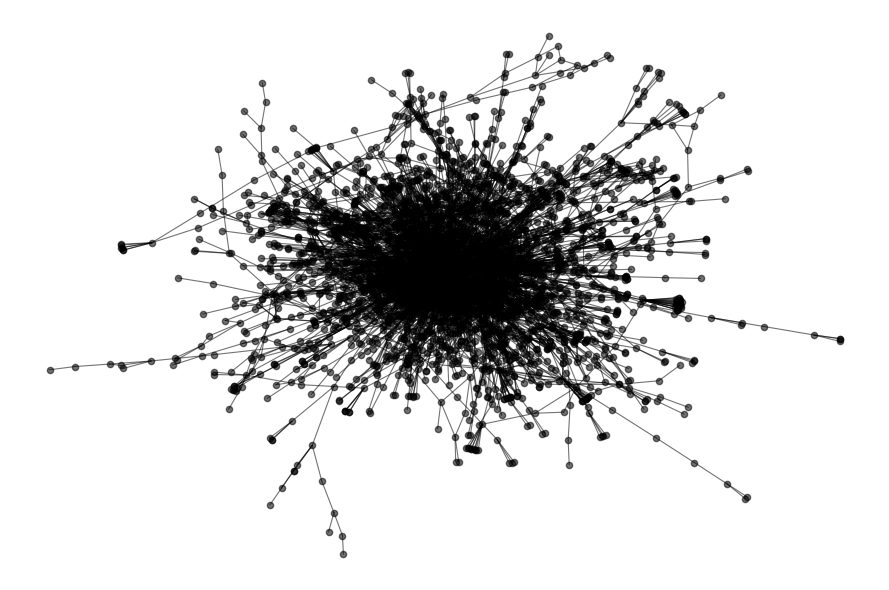

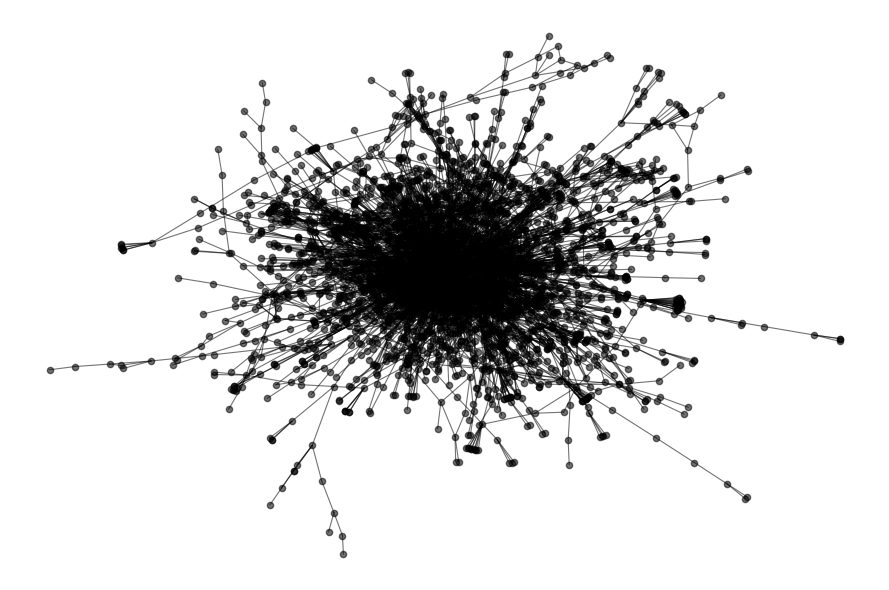

In [13]:
cu.plot_graph(graph)

Generated 10 random graphs with at least 99.0% of original edges (5648 edges)
3155
5648
Entropia de grafo: 37070 y tamaño de la codificación: 1606075
3155
5687
3155
5748
3155
5674
3155
5705
3155
5670
3155
5638
3155
5669
3155
5679
3155
5674
3155
5595
Entropia promedio de grafos random: 46210.30 y tamaño promedio de la codificación: 2176284.40
Generated 10 random graphs with at least 99.0% of original edges (4246 edges)
2209
4246
Entropia de grafo: 26893 y tamaño de la codificación: 784017
2209
4320
2209
4215
2209
4225
2209
4240
2209
4251
2209
4241
2209
4319
2209
4239
2209
4296
2209
4230
Entropia promedio de grafos random: 33212.50 y tamaño promedio de la codificación: 1147871.30
Generated 10 random graphs with at least 99.0% of original edges (3194 edges)
1547
3194
Entropia de grafo: 19084 y tamaño de la codificación: 385636
1547
3172
1547
3251
1547
3290
1547
3182
1547
3268
1547
3224
1547
3197
1547
3240
1547
3186
1547
3190
Entropia promedio de grafos random: 23982.50 y tamaño promedio d

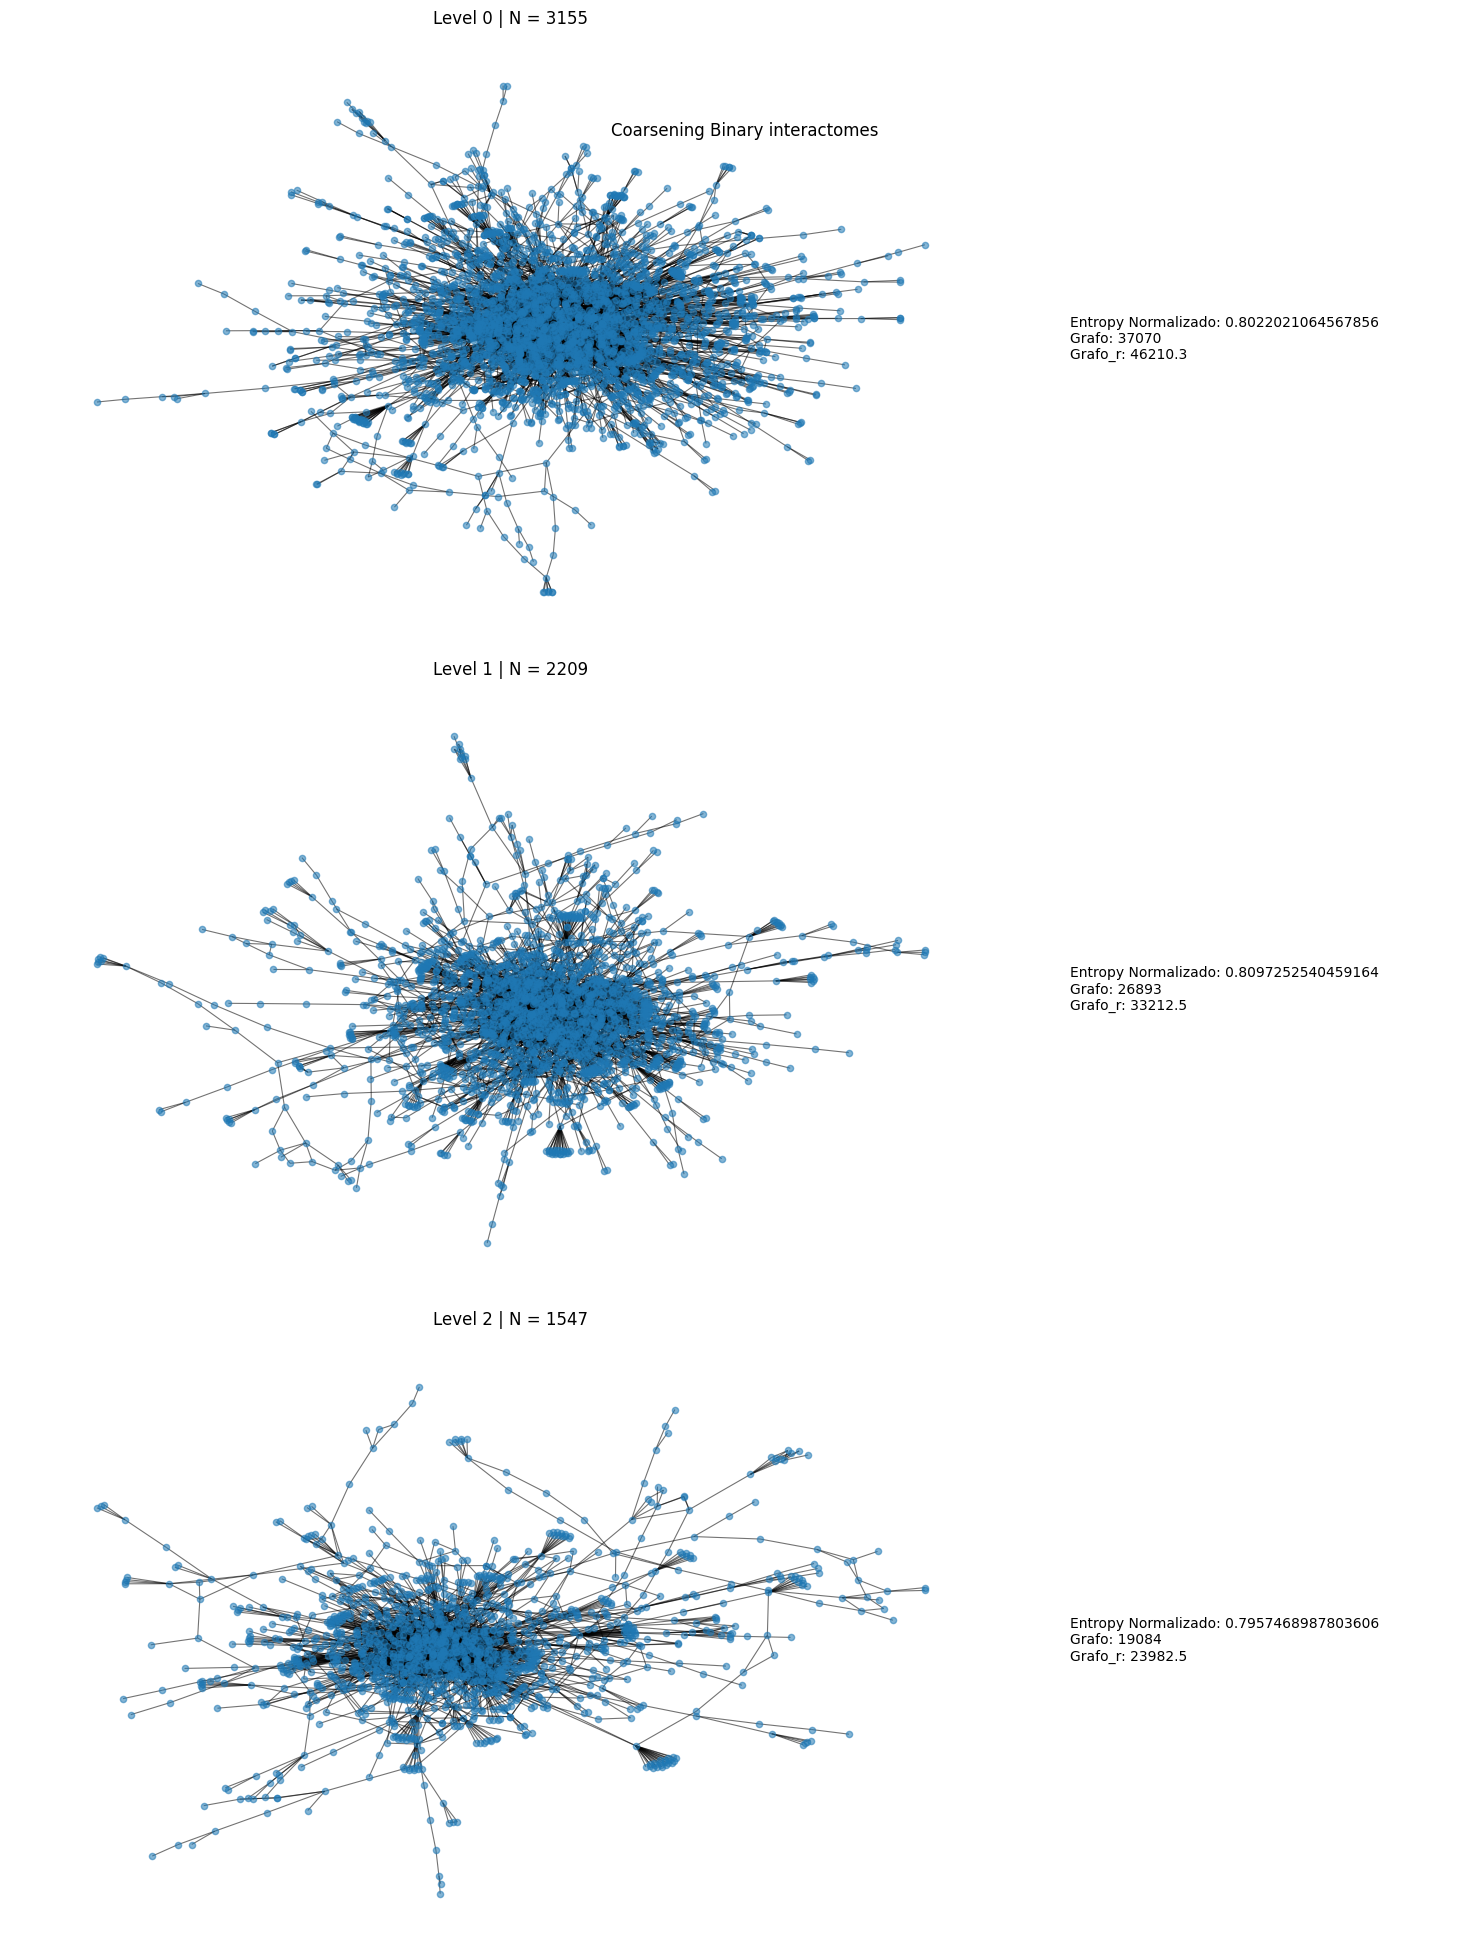

In [14]:
# Initial graph with 1000 nodes
G_nx = graph
W = nx.to_scipy_sparse_array(G_nx)
G = graphs.Graph(W)

# Calculate reduction ratios for each step
# Step 1: 1000 -> 750 (r = 0.25)
# Step 2: 750 -> 500 (r = 0.33)
r1 = 0.3  # reduces from 1000 to ~750
r2 = 0.3  # reduces from 750 to ~500

# First coarsening
C1, Gc1, Call1, Gall1 = coarsen(G, K=10, r=r1)
# Second coarsening starting from Gc1
C2, Gc2, Call2, Gall2 = coarsen(Gc1, K=10, r=r2)

# Combine all graphs in sequence
Gall = [nx.from_scipy_sparse_array(G.W) for G in [G] + Gall1[1:] + Gall2[1:]]

# Visualize
fig = plot_coarsening_vertical(Gall, "Arithmetic Encoding", title="Coarsening Binary interactomes")
plt.show()

### Experimento con los 60 grafos

In [ ]:
import pickle
import networkx as nx
import numpy as np
from pygsp import graphs
import json
from collections import defaultdict
from tqdm import tqdm  # For progress tracking
import pandas as pd

# Load the graph processing functions

import algorithm.calculo_entropia as ce

def create_networkx_graph(row):
    """Create a NetworkX graph from a row of the dataset."""
    is_directed = 'Directed' in row['graphProperties']
    G = nx.DiGraph() if is_directed else nx.Graph()
    
    nodes = np.array(row['nodes_id'])
    edges = np.array(row['edges_id'])
    
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def calculate_graph_metrics(G_nx):
    """Calculate basic metrics for a graph."""
    return {
        'number_nodes': G_nx.number_of_nodes(),
        'number_edges': G_nx.number_of_edges(),
        'ave_degree': 2 * G_nx.number_of_edges() / G_nx.number_of_nodes()
    }

def calculate_entropies(G_nx):
    """Calculate entropy metrics using arithmetic encoding method."""
    # Get entropy metrics directly using the helper function
    entropy_metrics = cu.get_entropy_metadata_aritmethicEncoding(G_nx)
    
    return {
        'entropy_arithmetic': {
            'graph': entropy_metrics['Grafo'],
            'random': entropy_metrics['Grafo_r'],
            'normalized': entropy_metrics['Entropy Normalizado']
        }
    }

def process_graph_at_reduction(G_nx, reduction_percent):
    """Process a graph at a specific reduction percentage."""
    # Convert to PyGSP format
    W = nx.to_scipy_sparse_array(G_nx)
    G = graphs.Graph(W)
    
    # Calculate reduction ratio
    r = 1 - (reduction_percent/100)
    
    if reduction_percent == 100:
        # Original graph, no reduction needed
        G_reduced = G_nx
    else:
        # Perform coarsening
        try:
            C, Gc, Call, Gall = coarsen(G, K=10, r=r)
            G_reduced = nx.from_scipy_sparse_array(Gc.W)
        except Exception as e:
            print(f"Error in coarsening at {reduction_percent}%: {str(e)}")
            return None
    
    # Calculate metrics and entropies
    metrics = calculate_graph_metrics(G_reduced)
    entropies = calculate_entropies(G_reduced)
    
    # Combine all information
    return {
        'graph_portion': reduction_percent,
        **metrics,
        **entropies
    }


def create_graph_family_json(df):
    """Create the complete JSON structure for all graph families."""
    result = defaultdict(lambda: defaultdict(dict))
    
    # Process each row in the dataframe
    for _, row in tqdm(df.iterrows(), total=len(df)):
        family = row['networkDomain']
        if not isinstance(family, str):
            continue
            
        graph_data = {
            'Name': row['network_name'],
            'Subdomain': row['subDomain'],
            'Node_Type': row['nodeType'],
            'Edge_Type': row['edgeType'],
            'reductions': {}
        }
        
        # Create NetworkX graph
        G_nx = create_networkx_graph(row)
        
        # Process each reduction percentage
        for reduction in [100, 80, 60, 40, 20]:
            reduction_data = process_graph_at_reduction(G_nx, reduction)
            if reduction_data:
                graph_data['reductions'][str(reduction)] = reduction_data
        
        # Add to result
        result[family][row['network_name']] = graph_data
    
    return dict(result)

# Load the data
with open('top_networks.pkl', 'rb') as f:
    real_graphs = pickle.load(f)

# Process all graphs and create JSON
graph_families = create_graph_family_json(real_graphs)

# Save to JSON file
with open('graph_families_analysis.json', 'w') as f:
    json.dump(graph_families, f, indent=2)

# Example of accessing the data
print("Available network domains:", list(graph_families.keys()))
for domain in graph_families:
    print(f"\n{domain} networks:", list(graph_families[domain].keys()))

In [7]:
import matplotlib.pyplot as plt
import json
import numpy as np

def plot_family_entropy_reductions(json_data, family_name, figsize=(12, 8)):
    # Set up the plot
    plt.figure(figsize=figsize)
    
    # Colors and markers for different graphs
    colors = plt.cm.rainbow(np.linspace(0, 1, len(json_data[family_name])))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    # Reduction levels for x-axis (reversed order)
    reduction_levels = [100, 80, 60, 40, 20]
    
    # Plot each graph's entropy reductions
    for (graph_name, graph_data), color, marker in zip(json_data[family_name].items(), colors, markers):
        # Extract normalized entropy values
        entropy_values = [graph_data['reductions'][str(level)]['entropy_arithmetic']['normalized'] 
                         for level in reduction_levels 
                         if str(level) in graph_data['reductions']]
        
        # Create shortened name for legend
        short_name = graph_name[:20] + '...' if len(graph_name) > 20 else graph_name
        
        # Plot with both lines and markers
        plt.plot(reduction_levels[:len(entropy_values)], entropy_values, 
                marker=marker, linestyle='-', linewidth=2, markersize=8,
                label=short_name, color=color, alpha=0.7)

    # Customize the plot
    plt.xlabel('Graph Portion (%)', fontsize=12)
    plt.ylabel('Normalized Entropy', fontsize=12)
    plt.title(f'Entropy Reduction Patterns for {family_name} Networks', fontsize=14)
    
    # Set x-axis ticks and reverse the axis
    plt.xticks(reduction_levels)
    plt.gca().invert_xaxis()
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    return plt.gcf()

# Load the JSON data
with open('graph_families_analysis.json', 'r') as f:
    json_data = json.load(f)

# Create plots for all families
for family_name in json_data.keys():
    fig = plot_family_entropy_reductions(json_data, family_name)
    plt.savefig(f'entropy_reduction_{family_name}.png', bbox_inches='tight', dpi=300)
    plt.close()

# Optional: Create a single figure with subplots for all families
def plot_all_families(json_data, figsize=(20, 15)):
    # Calculate number of rows needed (2 columns)
    n_families = len(json_data)
    n_rows = (n_families + 1) // 2  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)
    axes = axes.flatten()
    
    reduction_levels = [100, 80, 60, 40, 20]
    
    for idx, (family_name, family_data) in enumerate(json_data.items()):
        ax = axes[idx]
        
        # Colors and markers for different graphs
        colors = plt.cm.rainbow(np.linspace(0, 1, len(family_data)))
        markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
        
        # Plot each graph's entropy reductions
        for (graph_name, graph_data), color, marker in zip(family_data.items(), colors, markers):
            entropy_values = [graph_data['reductions'][str(level)]['entropy_arithmetic']['normalized'] 
                            for level in reduction_levels 
                            if str(level) in graph_data['reductions']]
            
            short_name = graph_name[:15] + '...' if len(graph_name) > 15 else graph_name
            
            ax.plot(reduction_levels[:len(entropy_values)], entropy_values, 
                   marker=marker, linestyle='-', linewidth=2, markersize=6,
                   label=short_name, color=color, alpha=0.7)
        
        ax.set_xlabel('Graph Portion (%)')
        ax.set_ylabel('Normalized Entropy')
        ax.set_title(f'{family_name} Networks')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xticks(reduction_levels)
        ax.invert_xaxis()
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Remove empty subplots if odd number of families
    if n_families % 2 != 0:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.savefig('entropy_reduction_all_families.png', bbox_inches='tight', dpi=300)
    plt.close()

# Create both individual plots and combined plot
plot_all_families(json_data)

# Prueba final con todos los grafos

In [ ]:
import pickle
import networkx as nx
import numpy as np
from pygsp import graphs
import json
from collections import defaultdict
from tqdm import tqdm  # For progress tracking
import pandas as pd

# Load the graph processing functions

import algorithm.calculo_entropia as ce

def create_networkx_graph(row):
    """Create a NetworkX graph from a row of the dataset."""
    is_directed = 'Directed' in row['graphProperties']
    G = nx.DiGraph() if is_directed else nx.Graph()
    
    nodes = np.array(row['nodes_id'])
    edges = np.array(row['edges_id'])
    
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def calculate_graph_metrics(G_nx):
    """Calculate basic metrics for a graph."""
    return {
        'number_nodes': G_nx.number_of_nodes(),
        'number_edges': G_nx.number_of_edges(),
        'ave_degree': 2 * G_nx.number_of_edges() / G_nx.number_of_nodes()
    }

def calculate_entropies(G_nx):
    """Calculate entropy metrics using arithmetic encoding method."""
    # Get entropy metrics directly using the helper function
    entropy_metrics = cu.get_entropy_metadata_aritmethicEncoding(G_nx)
    
    return {
        'entropy_arithmetic': {
            'graph': entropy_metrics['Grafo'],
            'random': entropy_metrics['Grafo_r'],
            'normalized': entropy_metrics['Entropy Normalizado']
        }
    }

def process_graph_at_reduction(G_nx, reduction_percent):
    """Process a graph at a specific reduction percentage."""
    # Convert to PyGSP format
    W = nx.to_scipy_sparse_array(G_nx)
    G = graphs.Graph(W)
    
    # Calculate reduction ratio
    r = 1 - (reduction_percent/100)
    
    if reduction_percent == 100:
        # Original graph, no reduction needed
        G_reduced = G_nx
    else:
        # Perform coarsening
        try:
            C, Gc, Call, Gall = coarsen(G, K=10, r=r)
            G_reduced = nx.from_scipy_sparse_array(Gc.W)
        except Exception as e:
            print(f"Error in coarsening at {reduction_percent}%: {str(e)}")
            return None
    
    # Calculate metrics and entropies
    metrics = calculate_graph_metrics(G_reduced)
    entropies = calculate_entropies(G_reduced)
    
    # Combine all information
    return {
        'graph_portion': reduction_percent,
        **metrics,
        **entropies
    }


def create_graph_family_json(df):
    """Create the complete JSON structure for all graph families."""
    result = defaultdict(lambda: defaultdict(dict))
    
    # Process each row in the dataframe
    for _, row in tqdm(df.iterrows(), total=len(df)):
        family = row['networkDomain']
        if not isinstance(family, str):
            continue
            
        graph_data = {
            'Name': row['network_name'],
            'Subdomain': row['subDomain'],
            'Node_Type': row['nodeType'],
            'Edge_Type': row['edgeType'],
            'reductions': {}
        }
        
        # Create NetworkX graph
        G_nx = create_networkx_graph(row)
        
        # Process each reduction percentage
        for reduction in [100, 80, 60, 40, 20]:
            reduction_data = process_graph_at_reduction(G_nx, reduction)
            if reduction_data:
                graph_data['reductions'][str(reduction)] = reduction_data
        
        # Add to result
        result[family][row['network_name']] = graph_data
    
    return dict(result)

# Load the data
with open('undirected_networks.pkl', 'rb') as f:
    real_graphs = pickle.load(f)

# Process all graphs and create JSON
graph_families = create_graph_family_json(real_graphs)

# Save to JSON file
with open('graph_families_analysis.json', 'w') as f:
    json.dump(graph_families, f, indent=2)

# Example of accessing the data
print("Available network domains:", list(graph_families.keys()))
for domain in graph_families:
    print(f"\n{domain} networks:", list(graph_families[domain].keys()))

In [15]:
def analyze_network_distributions(df):
    # Define ranges for nodes
    node_ranges = [
        (0, 50, '0-50'),
        (50, 100, '50-100'),
        (100, 300, '100-300'),
        (300, 500, '300-500'),
        (500, 1000, '500-1000'),
        (1000, float('inf'), '1000+')
    ]
    
    # Create dynamic ranges for edges
    max_edges = df['number_edges'].max()
    edge_ranges = [(0, 100, '0-100')]
    current = 100
    while current < max_edges:
        next_val = min(current + 500, 6000)
        if current >= 6000:
            edge_ranges.append((current, float('inf'), f'{current}+'))
            break
        edge_ranges.append((current, next_val, f'{current}-{next_val}'))
        current = next_val
    
    # Function to categorize values into ranges
    def categorize(value, ranges):
        for start, end, label in ranges:
            if start <= value < end:
                return label
        return ranges[-1][2]  # Return the last category for any larger values
    
    # Create analysis for each family
    results = {}
    
    for domain in df['networkDomain'].unique():
        domain_data = df[df['networkDomain'] == domain]
        
        # Analyze nodes
        node_dist = domain_data['number_nodes'].apply(
            lambda x: categorize(x, node_ranges)).value_counts().sort_index()
        
        # Analyze edges
        edge_dist = domain_data['number_edges'].apply(
            lambda x: categorize(x, edge_ranges)).value_counts().sort_index()
        
        results[domain] = {
            'total_graphs': len(domain_data),
            'nodes_distribution': node_dist.to_dict(),
            'edges_distribution': edge_dist.to_dict()
        }
    
    # Print formatted results
    print("Network Size Distribution Analysis")
    print("=================================")
    
    for domain, data in results.items():
        print(f"\n{domain} Networks (Total: {data['total_graphs']} graphs)")
        print("\nNode Distribution:")
        print("-----------------")
        for range_label, count in data['nodes_distribution'].items():
            percentage = (count / data['total_graphs']) * 100
            print(f"{range_label}: {count} graphs ({percentage:.1f}%)")
        
        print("\nEdge Distribution:")
        print("-----------------")
        for range_label, count in data['edges_distribution'].items():
            percentage = (count / data['total_graphs']) * 100
            print(f"{range_label}: {count} graphs ({percentage:.1f}%)")
    
    return results

# Load your pickle file
with open('undirected_networks.pkl', 'rb') as f:
    networks_df = pickle.load(f)

# Run the analysis
distribution_results = analyze_network_distributions(networks_df)

# Optional: Create a DataFrame view of the results
def create_distribution_dataframe(results):
    # Prepare data for nodes
    node_dfs = []
    edge_dfs = []
    
    for domain, data in results.items():
        # Nodes DataFrame
        node_dist = pd.Series(data['nodes_distribution'], name=domain)
        node_dfs.append(node_dist)
        
        # Edges DataFrame
        edge_dist = pd.Series(data['edges_distribution'], name=domain)
        edge_dfs.append(edge_dist)
    
    nodes_df = pd.concat(node_dfs, axis=1).fillna(0).astype(int)
    edges_df = pd.concat(edge_dfs, axis=1).fillna(0).astype(int)
    
    print("\nNode Distribution Summary:")
    print(nodes_df)
    print("\nEdge Distribution Summary:")
    print(edges_df)
    
    return nodes_df, edges_df

# Create and display summary DataFrames
nodes_summary, edges_summary = create_distribution_dataframe(distribution_results)

Network Size Distribution Analysis

Biological Networks (Total: 151 graphs)

Node Distribution:
-----------------
0-50: 32 graphs (21.2%)
100-300: 45 graphs (29.8%)
1000+: 7 graphs (4.6%)
300-500: 19 graphs (12.6%)
50-100: 21 graphs (13.9%)
500-1000: 27 graphs (17.9%)

Edge Distribution:
-----------------
0-100: 36 graphs (23.8%)
100-600: 63 graphs (41.7%)
1100-1600: 15 graphs (9.9%)
1600-2100: 8 graphs (5.3%)
2100-2600: 10 graphs (6.6%)
2600-3100: 3 graphs (2.0%)
3100-3600: 2 graphs (1.3%)
3600-4100: 1 graphs (0.7%)
5600-6000: 1 graphs (0.7%)
600-1100: 11 graphs (7.3%)
6000+: 1 graphs (0.7%)

Social Networks (Total: 123 graphs)

Node Distribution:
-----------------
0-50: 6 graphs (4.9%)
100-300: 8 graphs (6.5%)
300-500: 44 graphs (35.8%)
50-100: 2 graphs (1.6%)
500-1000: 63 graphs (51.2%)

Edge Distribution:
-----------------
0-100: 4 graphs (3.3%)
100-600: 5 graphs (4.1%)
1100-1600: 15 graphs (12.2%)
1600-2100: 34 graphs (27.6%)
2100-2600: 37 graphs (30.1%)
2600-3100: 23 graphs (18.7

In [19]:
import matplotlib.pyplot as plt
import json
import numpy as np
from cycler import cycler

def safe_get_entropy_value(graph_data, level):
    """Safely get entropy value, return None if not available."""
    try:
        return graph_data['reductions'][str(level)]['entropy_arithmetic']['normalized']
    except (KeyError, TypeError):
        return None

def safe_get_node_count(graph_data):
    """Safely get node count, return None if not available."""
    try:
        return graph_data['reductions']['100']['number_nodes']
    except (KeyError, TypeError):
        return None

def safe_get_edge_count(graph_data):
    """Safely get edge count, return None if not available."""
    try:
        return graph_data['reductions']['100']['number_edges']
    except (KeyError, TypeError):
        return None

def get_nodes_in_range(graph_data, min_nodes, max_nodes):
    node_count = safe_get_node_count(graph_data)
    if node_count is None:
        return False
    return min_nodes <= node_count < max_nodes

def get_edges_in_range(graph_data, min_edges, max_edges):
    edge_count = safe_get_edge_count(graph_data)
    if edge_count is None:
        return False
    return min_edges <= edge_count < max_edges

def get_valid_entropy_values(graph_data, reduction_levels):
    """Get entropy values and their corresponding levels."""
    values = []
    valid_levels = []
    for level in reduction_levels:
        value = safe_get_entropy_value(graph_data, level)
        if value is not None:
            values.append(value)
            valid_levels.append(level)
    return valid_levels, values

def plot_entropy_by_node_range(json_data, node_range, figsize=(24, 18)):
    min_nodes, max_nodes = node_range
    range_label = f"{min_nodes}-{max_nodes if max_nodes != float('inf') else '+'}"
    
    n_families = len(json_data)
    n_rows = (n_families + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)
    axes = axes.flatten()
    
    reduction_levels = [100, 80, 60, 40, 20]
    
    for idx, (family_name, family_data) in enumerate(json_data.items()):
        ax = axes[idx]
        
        filtered_graphs = {name: data for name, data in family_data.items() 
                         if get_nodes_in_range(data, min_nodes, max_nodes)}
        
        if filtered_graphs:
            n_graphs = len(filtered_graphs)
            colors = plt.cm.rainbow(np.linspace(0, 1, n_graphs))
            markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
            
            for graph_idx, (graph_name, graph_data) in enumerate(filtered_graphs.items()):
                valid_levels, entropy_values = get_valid_entropy_values(graph_data, reduction_levels)
                
                if valid_levels:  # Only plot if we have valid data
                    node_count = safe_get_node_count(graph_data)
                    short_name = f"{graph_name[:20]}... ({node_count} nodes)"
                    
                    ax.plot(valid_levels, entropy_values,
                           marker=markers[graph_idx % len(markers)],
                           linestyle='-',
                           linewidth=1.5,
                           markersize=6,
                           label=short_name,
                           color=colors[graph_idx],
                           alpha=0.7)
        
        ax.set_xlabel('Graph Portion (%)', fontsize=10)
        ax.set_ylabel('Normalized Entropy', fontsize=10)
        ax.set_title(f'{family_name} Networks\n{range_label} nodes (n={len(filtered_graphs)})', 
                    fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_xticks(reduction_levels)
        ax.invert_xaxis()
        ax.set_ylim(0.5, 1.1)
        
        if len(filtered_graphs) > 0:
            ax.legend(bbox_to_anchor=(1.05, 1),
                     loc='upper left',
                     borderaxespad=0.,
                     fontsize=8)
    
    for idx in range(len(json_data), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle(f'Entropy Reduction Patterns for Networks with {range_label} Nodes',
                 fontsize=16,
                 y=1.02)
    plt.tight_layout()
    return fig

# Load the JSON data
with open('graph_families_analysis.json', 'r') as f:
    json_data = json.load(f)

# Define node ranges
node_ranges = [
    (0, 50),
    (50, 100),
    (100, 300),
    (300, 500),
    (500, 1000),
    (1000, float('inf'))
]

# Create node-based plots
for node_range in node_ranges:
    try:
        fig = plot_entropy_by_node_range(json_data, node_range)
        min_nodes, max_nodes = node_range
        range_label = f"{min_nodes}-{max_nodes if max_nodes != float('inf') else 'plus'}"
        plt.savefig(f'entropy_by_nodes_{range_label}.png',
                    bbox_inches='tight',
                    dpi=300)
        plt.close()
    except Exception as e:
        print(f"Error plotting node range {node_range}: {str(e)}")

/tmp/ipykernel_2042/2780920952.py:109: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


In [20]:
def plot_entropy_by_edge_range(json_data, edge_range, figsize=(24, 18)):
    min_edges, max_edges = edge_range
    range_label = f"{min_edges}-{max_edges if max_edges != float('inf') else '+'}"
    
    n_families = len(json_data)
    n_rows = (n_families + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)
    axes = axes.flatten()
    
    reduction_levels = [100, 80, 60, 40, 20]
    
    for idx, (family_name, family_data) in enumerate(json_data.items()):
        ax = axes[idx]
        
        filtered_graphs = {name: data for name, data in family_data.items() 
                         if get_edges_in_range(data, min_edges, max_edges)}
        
        if filtered_graphs:
            n_graphs = len(filtered_graphs)
            colors = plt.cm.rainbow(np.linspace(0, 1, n_graphs))
            markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
            
            for graph_idx, (graph_name, graph_data) in enumerate(filtered_graphs.items()):
                valid_levels, entropy_values = get_valid_entropy_values(graph_data, reduction_levels)
                
                if valid_levels:  # Only plot if we have valid data
                    edge_count = safe_get_edge_count(graph_data)
                    short_name = f"{graph_name[:20]}... ({edge_count} edges)"
                    
                    ax.plot(valid_levels, entropy_values,
                           marker=markers[graph_idx % len(markers)],
                           linestyle='-',
                           linewidth=1.5,
                           markersize=6,
                           label=short_name,
                           color=colors[graph_idx],
                           alpha=0.7)
        
        ax.set_xlabel('Graph Portion (%)', fontsize=10)
        ax.set_ylabel('Normalized Entropy', fontsize=10)
        ax.set_title(f'{family_name} Networks\n{range_label} edges (n={len(filtered_graphs)})', 
                    fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_xticks(reduction_levels)
        ax.invert_xaxis()
        ax.set_ylim(0.5, 1.1)
        
        if len(filtered_graphs) > 0:
            ax.legend(bbox_to_anchor=(1.05, 1),
                     loc='upper left',
                     borderaxespad=0.,
                     fontsize=8)
    
    for idx in range(len(json_data), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle(f'Entropy Reduction Patterns for Networks with {range_label} Edges',
                 fontsize=16,
                 y=1.02)
    plt.tight_layout()
    return fig

# Define edge ranges
edge_ranges = [
    (0, 100),
    (100, 600),
    (600, 1100),
    (1100, 1600),
    (1600, 2100),
    (2100, 2600),
    (2600, 3100),
    (3100, float('inf'))
]

# Create edge-based plots
for edge_range in edge_ranges:
    try:
        fig = plot_entropy_by_edge_range(json_data, edge_range)
        min_edges, max_edges = edge_range
        range_label = f"{min_edges}-{max_edges if max_edges != float('inf') else 'plus'}"
        plt.savefig(f'entropy_by_edges_{range_label}.png',
                    bbox_inches='tight',
                    dpi=300)
        plt.close()
    except Exception as e:
        print(f"Error plotting edge range {edge_range}: {str(e)}")

In [21]:
import matplotlib.pyplot as plt
import json
import numpy as np
from cycler import cycler

def get_y_axis_limits(entropy_values_list, padding=0.1):
    """Calculate appropriate y-axis limits based on data"""
    all_values = []
    for values in entropy_values_list:
        all_values.extend([v for v in values if v is not None])
    
    if not all_values:
        return 0.5, 1.1
    
    min_val = min(all_values)
    max_val = max(all_values)
    
    # Add padding
    range_val = max_val - min_val
    min_val = max(0, min_val - range_val * padding)
    max_val = max_val + range_val * padding
    
    return min_val, max_val

def plot_entropy_by_range(json_data, range_type, value_range, figsize=(30, 22)):
    min_val, max_val = value_range
    range_label = f"{min_val}-{max_val if max_val != float('inf') else '+'}"
    
    # Set up subplot grid with larger figsize
    n_families = len(json_data)
    n_rows = (n_families + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)
    axes = axes.flatten()
    
    reduction_levels = [100, 80, 60, 40, 20]
    
    # Store all entropy values for y-axis scaling
    all_entropy_values = []
    
    # First pass to collect all entropy values
    for family_name, family_data in json_data.items():
        filtered_graphs = {}
        for name, data in family_data.items():
            try:
                if range_type == 'nodes':
                    value = data['reductions']['100']['number_nodes']
                else:  # edges
                    value = data['reductions']['100']['number_edges']
                
                if min_val <= value < max_val:
                    valid_levels, entropy_values = get_valid_entropy_values(data, reduction_levels)
                    if entropy_values:
                        all_entropy_values.append(entropy_values)
            except (KeyError, TypeError):
                continue
    
    # Get y-axis limits based on all data
    y_min, y_max = get_y_axis_limits(all_entropy_values)
    
    # Second pass to create plots
    for idx, (family_name, family_data) in enumerate(json_data.items()):
        ax = axes[idx]
        
        # Filter graphs in range
        filtered_graphs = {}
        for name, data in family_data.items():
            try:
                if range_type == 'nodes':
                    value = data['reductions']['100']['number_nodes']
                else:  # edges
                    value = data['reductions']['100']['number_edges']
                
                if min_val <= value < max_val:
                    filtered_graphs[name] = data
            except (KeyError, TypeError):
                continue
        
        if filtered_graphs:
            n_graphs = len(filtered_graphs)
            colors = plt.cm.rainbow(np.linspace(0, 1, n_graphs))
            markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
            
            for graph_idx, (graph_name, graph_data) in enumerate(filtered_graphs.items()):
                valid_levels, entropy_values = get_valid_entropy_values(graph_data, reduction_levels)
                
                if valid_levels:
                    if range_type == 'nodes':
                        value = graph_data['reductions']['100']['number_nodes']
                        short_name = f"{graph_name[:20]}... ({value} nodes)"
                    else:
                        value = graph_data['reductions']['100']['number_edges']
                        short_name = f"{graph_name[:20]}... ({value} edges)"
                    
                    ax.plot(valid_levels, entropy_values,
                           marker=markers[graph_idx % len(markers)],
                           linestyle='-',
                           linewidth=2,
                           markersize=8,
                           label=short_name,
                           color=colors[graph_idx],
                           alpha=0.8)
        
        ax.set_xlabel('Graph Portion (%)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Normalized Entropy', fontsize=12, fontweight='bold')
        title = f'{family_name} Networks\n{range_label} {range_type} (n={len(filtered_graphs)})'
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_xticks(reduction_levels)
        ax.invert_xaxis()
        
        # Set y-axis limits with padding
        ax.set_ylim(y_min, y_max)
        
        if len(filtered_graphs) > 0:
            ax.legend(bbox_to_anchor=(1.05, 1),
                     loc='upper left',
                     borderaxespad=0.,
                     fontsize=10)
        
        # Increase tick label sizes
        ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Remove empty subplots
    for idx in range(len(json_data), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle(f'Entropy Reduction Patterns for Networks with {range_label} {range_type.capitalize()}',
                 fontsize=16,
                 fontweight='bold',
                 y=1.02)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.95, 0.95], h_pad=2, w_pad=3)
    return fig

# Load the data
with open('graph_families_analysis.json', 'r') as f:
    json_data = json.load(f)

# Define ranges
node_ranges = [
    (0, 50),
    (50, 100),
    (100, 300),
    (300, 500),
    (500, 1000),
    (1000, float('inf'))
]

edge_ranges = [
    (0, 100),
    (100, 600),
    (600, 1100),
    (1100, 1600),
    (1600, 2100),
    (2100, 2600),
    (2600, 3100),
    (3100, float('inf'))
]

# Create node-based plots
for node_range in node_ranges:
    try:
        fig = plot_entropy_by_range(json_data, 'nodes', node_range)
        min_nodes, max_nodes = node_range
        range_label = f"{min_nodes}-{max_nodes if max_nodes != float('inf') else 'plus'}"
        plt.savefig(f'entropy_by_nodes_{range_label}.png',
                    bbox_inches='tight',
                    dpi=300)
        plt.close()
    except Exception as e:
        print(f"Error plotting node range {node_range}: {str(e)}")

# Create edge-based plots
for edge_range in edge_ranges:
    try:
        fig = plot_entropy_by_range(json_data, 'edges', edge_range)
        min_edges, max_edges = edge_range
        range_label = f"{min_edges}-{max_edges if max_edges != float('inf') else 'plus'}"
        plt.savefig(f'entropy_by_edges_{range_label}.png',
                    bbox_inches='tight',
                    dpi=300)
        plt.close()
    except Exception as e:
        print(f"Error plotting edge range {edge_range}: {str(e)}")

/tmp/ipykernel_2042/1630920336.py:134: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95], h_pad=2, w_pad=3)


In [28]:
import matplotlib.pyplot as plt
import json
import numpy as np
from cycler import cycler

def get_nodes_in_range(graph_data, min_nodes, max_nodes):
    try:
        nodes = graph_data['reductions']['100']['number_nodes']
        return min_nodes <= nodes < max_nodes
    except (KeyError, TypeError):
        return False

def safe_get_entropy_value(graph_data, level):
    """Safely get entropy value, return None if not available."""
    try:
        return graph_data['reductions'][str(level)]['entropy_arithmetic']['normalized']
    except (KeyError, TypeError):
        return None

def get_valid_entropy_values(graph_data, reduction_levels):
    """Get entropy values and their corresponding levels."""
    values = []
    valid_levels = []
    for level in reduction_levels:
        value = safe_get_entropy_value(graph_data, level)
        if value is not None:
            values.append(value)
            valid_levels.append(level)
    return valid_levels, values

def get_y_axis_limits(entropy_values_list, padding=0.1):
    """Calculate appropriate y-axis limits based on data"""
    all_values = []
    
    # Handle both list of lists and list of floats
    for values in entropy_values_list:
        if isinstance(values, (list, tuple)):
            all_values.extend([v for v in values if v is not None])
        elif isinstance(values, (int, float)):
            all_values.append(values)
    
    if not all_values:
        return 0.5, 1.1
    
    min_val = min(all_values)
    max_val = max(all_values)
    
    # Add padding
    range_val = max_val - min_val
    min_val = max(0, min_val - range_val * padding)
    max_val = max_val + range_val * padding
    
    return min_val, max_val

def plot_family_specific(json_data, family_name, node_ranges, figsize=(25, 20)):
    n_ranges = len(node_ranges)
    n_cols = 2
    n_rows = (n_ranges + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1:
        axes = np.array([axes])
    elif n_cols == 1:
        axes = np.array([[ax] for ax in axes])
    axes = axes.flatten()
    
    reduction_levels = [100, 80, 60, 40, 20]
    family_data = json_data[family_name]
    
    # First pass to get global y-axis limits
    all_entropy_values = []
    for min_nodes, max_nodes in node_ranges:
        filtered_graphs = {name: data for name, data in family_data.items() 
                         if get_nodes_in_range(data, min_nodes, max_nodes)}
        
        for graph_data in filtered_graphs.values():
            _, values = get_valid_entropy_values(graph_data, reduction_levels)
            all_entropy_values.extend(values)  # values is already a list
    
    y_min, y_max = get_y_axis_limits(all_entropy_values)
    
    # Plot each range in its own subplot
    for range_idx, (min_nodes, max_nodes) in enumerate(node_ranges):
        ax = axes[range_idx]
        range_label = f"{min_nodes}-{max_nodes if max_nodes != float('inf') else '+'}"
        
        filtered_graphs = {name: data for name, data in family_data.items() 
                         if get_nodes_in_range(data, min_nodes, max_nodes)}
        
        if filtered_graphs:
            n_graphs = len(filtered_graphs)
            colors = plt.cm.rainbow(np.linspace(0, 1, n_graphs))
            
            for graph_idx, (graph_name, graph_data) in enumerate(filtered_graphs.items()):
                valid_levels, entropy_values = get_valid_entropy_values(graph_data, reduction_levels)
                
                if valid_levels:
                    node_count = graph_data['reductions']['100']['number_nodes']
                    short_name = f"{graph_name[:20]}... ({node_count})"
                    
                    ax.plot(valid_levels, entropy_values,
                           marker='o',
                           linestyle='-',
                           linewidth=1.5,
                           markersize=6,
                           label=short_name,
                           color=colors[graph_idx],
                           alpha=0.7)
        
        ax.set_xlabel('Graph Portion (%)', fontsize=10)
        ax.set_ylabel('Normalized Entropy', fontsize=10)
        ax.set_title(f'Range: {range_label} nodes (n={len(filtered_graphs)})', 
                    fontsize=12)
        
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_xticks(reduction_levels)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.invert_xaxis()
        ax.set_ylim(y_min, y_max)
        
        if len(filtered_graphs) > 0:
            ax.legend(bbox_to_anchor=(1.02, 1),
                     loc='upper left',
                     borderaxespad=0.,
                     fontsize=8,
                     ncol=1)
    
    # Remove empty subplots
    for idx in range(len(node_ranges), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle(f'Entropy Reduction Patterns for {family_name} Networks',
                 fontsize=16,
                 fontweight='bold',
                 y=0.95)
    
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    return fig

# Define custom ranges for each family
family_ranges = {
    'Biological': [(0, 50), (50, 100), (100, 300), (300, 500), (500, 1000), (1000, float('inf'))],
    'Economic': [(0, 300), (300, 500), (500, 1000), (1000, float('inf'))],
    'Informational': [(0, 50), (50, 100), (100, 300), (1000, float('inf'))],
    'Social': [(0, 100), (100, 300), (300, 400), (400, 500), (500, 600), (600, float('inf'))],
    'Technological': [(100, 300), (300, 500), (500, 1000), (1000, float('inf'))],
    'Transportation': [(100, 300), (300, 500), (500, 1000), (1000, float('inf'))]
}

# Load data and create plots
with open('graph_families_analysis.json', 'r') as f:
    json_data = json.load(f)

# Create family-specific plots
for family_name, ranges in family_ranges.items():
    
    fig = plot_family_specific(json_data, family_name, ranges)
    if fig is not None:
        plt.savefig(f'entropy_{family_name}_by_ranges.png',
                   bbox_inches='tight',
                   dpi=300)
        plt.close()


# Comparacion con grafos teoricos

## Creacion y prueba con grafos teoricos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs
import networkx as nx
import pickle

# Set parameters
node_sizes = [2500, 1500, 500]
num_graphs = 10

# Dictionary to store all graphs
# Structure: graphs_dict[graph_type][node_size] = list_of_graphs
graphs_dict = {
    'ring': {size: [] for size in node_sizes},
    'barabasi': {size: [] for size in node_sizes},
    'regular': {size: [] for size in node_sizes},
    'grid': {size: [] for size in node_sizes}
}

# Create graphs for each type and size
for N in node_sizes:
    print(f"\nCreating graphs with {N} nodes...")
    
    for i in range(num_graphs):
        print(f"Creating set {i+1}/{num_graphs}...")
        
        # 1. Ring Graph with random edges
        G_ring = graphs.Ring(N=N, k=1)
        p = 0.005
        for u in range(N):
            for v in range(u+2, N):
                if np.random.random() < p:
                    G_ring.W[u, v] = G_ring.W[v, u] = 1
        graphs_dict['ring'][N].append(G_ring)
        
        # 2. Barabasi-Albert Graph
        G_ba = graphs.BarabasiAlbert(N=N)
        graphs_dict['barabasi'][N].append(G_ba)
        
        # 3. Random Regular Graph
        G_nx_regular = nx.random_regular_graph(d=5, n=N)
        W_regular = nx.adjacency_matrix(G_nx_regular)
        G_regular = graphs.Graph(W_regular)
        graphs_dict['regular'][N].append(G_regular)
        
        # 4. Grid Graph
        # Calculate grid dimensions
        m, n = int(np.sqrt(N)), int(np.sqrt(N))
        while m * n != N:
            m -= 1
            n = N // m
        G_nx_grid = nx.grid_2d_graph(m=m, n=n)
        W_grid = nx.adjacency_matrix(G_nx_grid)
        G_grid = graphs.Graph(W_grid)
        graphs_dict['grid'][N].append(G_grid)

# Save all graphs in one file
print("\nSaving all graphs...")
with open('all_graphs.pkl', 'wb') as f:
    pickle.dump(graphs_dict, f)
print("Saved all graphs to all_graphs.pkl")

# Print information about the saved graphs
print("\nGraph Information:")
for graph_type in graphs_dict:
    print(f"\n{graph_type.upper()} Graphs:")
    for size in node_sizes:
        num_graphs = len(graphs_dict[graph_type][size])
        sample_graph = graphs_dict[graph_type][size][0]
        print(f"\nSize {size}:")
        print(f"Number of graphs: {num_graphs}")
        print(f"Nodes per graph: {sample_graph.N}")
        print(f"Edges per graph: {sample_graph.W.nnz//2}")

In [2]:
print(graphs_dict)

{'ring': {2500: [<pygsp.graphs.ring.Ring object at 0x7f2f25309520>, <pygsp.graphs.ring.Ring object at 0x7f2ee40ee070>, <pygsp.graphs.ring.Ring object at 0x7f2ee2f08e20>, <pygsp.graphs.ring.Ring object at 0x7f2ee41d8d30>, <pygsp.graphs.ring.Ring object at 0x7f2ee30bbdf0>, <pygsp.graphs.ring.Ring object at 0x7f2ee1e6fd30>, <pygsp.graphs.ring.Ring object at 0x7f2ee38a9dc0>, <pygsp.graphs.ring.Ring object at 0x7f2ee0e11d30>, <pygsp.graphs.ring.Ring object at 0x7f2ee2fd0d60>, <pygsp.graphs.ring.Ring object at 0x7f2ee2067fa0>], 1500: [<pygsp.graphs.ring.Ring object at 0x7f2ee388b490>, <pygsp.graphs.ring.Ring object at 0x7f2edf8c5f40>, <pygsp.graphs.ring.Ring object at 0x7f2ee1043fa0>, <pygsp.graphs.ring.Ring object at 0x7f2ee0514e80>, <pygsp.graphs.ring.Ring object at 0x7f2edf4eaf70>, <pygsp.graphs.ring.Ring object at 0x7f2ee012c580>, <pygsp.graphs.ring.Ring object at 0x7f2edecbdd30>, <pygsp.graphs.ring.Ring object at 0x7f2edf79a0a0>, <pygsp.graphs.ring.Ring object at 0x7f2edea79cd0>, <pygsp

In [ ]:
import networkx as nx
import numpy as np
from pygsp import graphs
import json

def get_graph_edges(graph):
    """Safely get number of edges from a PyGSP graph"""
    try:
        # Try to use the stored number of edges
        return graph.Ne
    except AttributeError:
        try:
            # Calculate from the weight matrix
            return int(graph.W.nnz / 2)  # Divide by 2 for undirected graphs
        except:
            # Count non-zero elements in adjacency matrix
            return int(np.sum(graph.W.toarray() > 0) / 2)

def process_synthetic_graphs(synthetic_graphs):
    """Convert synthetic graphs data into our analysis format"""
    json_data = {}
    
    for family_name, size_dict in synthetic_graphs.items():
        print(f"\nProcessing {family_name} graphs...")
        family_data = {}
        
        for size, graph_list in size_dict.items():
            print(f"Processing size {size}, {len(graph_list)} graphs")
            
            # Process each graph in the list
            for idx, graph in enumerate(graph_list):
                graph_name = f"{family_name}_{size}_{idx}"
                print(f"Processing {graph_name}")
                
                # Initialize reduction data
                reductions = {}
                current_graph = graph
                
                try:
                    # Calculate initial metrics
                    N = current_graph.N  # Original number of nodes
                    E = get_graph_edges(current_graph)  # Original number of edges
                    
                    # Store original graph metrics (100%)
                    reductions['100'] = {
                        'number_nodes': N,
                        'number_edges': E,
                        'ave_degree': 2 * E / N if N > 0 else 0,
                    }
                    
                    # Perform reductions
                    for reduction in [80, 60, 40, 20]:
                        try:
                            # Calculate reduction ratio
                            r = 1 - (reduction/100)
                            
                            # Perform coarsening
                            C, Gc, Call, Gall = coarsen(current_graph, K=10, r=r)
                            
                            if Gc is not None:
                                n = Gc.N  # Number of nodes after reduction
                                e = get_graph_edges(Gc)  # Number of edges after reduction
                                
                                reductions[str(reduction)] = {
                                    'number_nodes': n,
                                    'number_edges': e,
                                    'ave_degree': 2 * e / n if n > 0 else 0,
                                }
                                
                                # Calculate entropy metrics
                                G_nx = nx.from_scipy_sparse_array(Gc.W)
                                entropy_metrics = get_entropy_metadata_aritmethicEncoding(G_nx)
                                
                                reductions[str(reduction)]['entropy_arithmetic'] = {
                                    'graph': entropy_metrics['Grafo'],
                                    'random': entropy_metrics['Grafo_r'],
                                    'normalized': entropy_metrics['Entropy Normalizado']
                                }
                                
                        except Exception as e:
                            print(f"Error in reduction {reduction}% for {graph_name}: {str(e)}")
                            continue
                    
                    # Calculate entropy metrics for original graph
                    try:
                        G_nx = nx.from_scipy_sparse_array(graph.W)
                        entropy_metrics = get_entropy_metadata_aritmethicEncoding(G_nx)
                        reductions['100']['entropy_arithmetic'] = {
                            'graph': entropy_metrics['Grafo'],
                            'random': entropy_metrics['Grafo_r'],
                            'normalized': entropy_metrics['Entropy Normalizado']
                        }
                    except Exception as e:
                        print(f"Error calculating original entropy for {graph_name}: {str(e)}")
                    
                    # Add to family data
                    family_data[graph_name] = {
                        'Name': graph_name,
                        'Subdomain': 'Synthetic',
                        'Node_Type': 'Vertex',
                        'Edge_Type': family_name,
                        'reductions': reductions
                    }
                    
                except Exception as e:
                    print(f"Error processing graph {graph_name}: {str(e)}")
                    continue
        
        json_data[family_name] = family_data
    
    return json_data

# Define ranges for synthetic graphs
synthetic_ranges = {
    'ring': [(0, 1000), (1000, 2000), (2000, float('inf'))],
    'barabasi': [(0, 1000), (1000, 2000), (2000, float('inf'))],
    'regular': [(0, 1000), (1000, 2000), (2000, float('inf'))],
    'grid': [(0, 1000), (1000, 2000), (2000, float('inf'))]
}

# Load and process the data
try:
    print("Loading synthetic graphs...")
    with open('all_graphs.pkl', 'rb') as f:
        synthetic_graphs = pickle.load(f)
    
    print("Processing graphs...")
    json_data = process_synthetic_graphs(synthetic_graphs)
    
    print("Saving processed data...")
    with open('synthetic_graphs_analysis.json', 'w') as f:
        json.dump(json_data, f, indent=2)
    
    print("Creating plots...")
    for family_name, ranges in synthetic_ranges.items():
        try:
            fig = plot_family_specific(json_data, family_name, ranges)
            if fig is not None:
                plt.savefig(f'entropy_{family_name}_synthetic_by_ranges.png',
                           bbox_inches='tight',
                           dpi=300)
                plt.close()
        except Exception as e:
            print(f"Error plotting {family_name}: {str(e)}")
            
except Exception as e:
    print(f"Error in main execution: {str(e)}")
    import traceback
    traceback.print_exc()

In [10]:
def plot_size_specific(json_data, node_size, figsize=(15, 10)):
    """Plot all families for a specific node size."""
    fig, ax = plt.subplots(figsize=figsize)
    reduction_levels = [100, 80, 60, 40, 20]
    
    # Different color for each family
    colors = {'ring': 'blue', 'barabasi': 'red', 'regular': 'green', 'grid': 'purple'}
    markers = {'ring': 'o', 'barabasi': 's', 'regular': '^', 'grid': 'D'}
    
    for family_name in ['ring', 'barabasi', 'regular', 'grid']:
        entropy_values = []
        
        # Get all graphs of this size for this family
        for graph_name, graph_data in json_data[family_name].items():
            if f"{node_size}" in graph_name:
                values = [graph_data['reductions'][str(level)]['entropy_arithmetic']['normalized'] 
                         for level in reduction_levels]
                entropy_values.append(values)
        
        # Plot average with error bars
        if entropy_values:
            mean_values = np.mean(entropy_values, axis=0)
            std_values = np.std(entropy_values, axis=0)
            
            ax.errorbar(reduction_levels, mean_values, yerr=std_values,
                       label=f'{family_name}',
                       color=colors[family_name],
                       marker=markers[family_name],
                       markersize=8,
                       linewidth=2,
                       capsize=5)
    
    ax.set_xlabel('Graph Portion (%)', fontsize=12)
    ax.set_ylabel('Normalized Entropy', fontsize=12)
    ax.set_title(f'Entropy Reduction Patterns for {node_size}-node Networks', 
                 fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xticks(reduction_levels)
    ax.invert_xaxis()
    ax.legend()
    plt.tight_layout()
    return fig

def plot_family_sizes(json_data, family_name, figsize=(15, 10)):
    """Plot all sizes for a specific family."""
    fig, ax = plt.subplots(figsize=figsize)
    reduction_levels = [100, 80, 60, 40, 20]
    
    colors = {500: 'blue', 1500: 'red', 2500: 'green'}
    markers = {500: 'o', 1500: 's', 2500: '^'}
    
    for size in [500, 1500, 2500]:
        entropy_values = []
        
        # Get all graphs of this size
        for graph_name, graph_data in json_data[family_name].items():
            if f"{size}" in graph_name:
                values = [graph_data['reductions'][str(level)]['entropy_arithmetic']['normalized'] 
                         for level in reduction_levels]
                entropy_values.append(values)
        
        # Plot average with error bars
        if entropy_values:
            mean_values = np.mean(entropy_values, axis=0)
            std_values = np.std(entropy_values, axis=0)
            
            ax.errorbar(reduction_levels, mean_values, yerr=std_values,
                       label=f'{size} nodes',
                       color=colors[size],
                       marker=markers[size],
                       markersize=8,
                       linewidth=2,
                       capsize=5)
    
    ax.set_xlabel('Graph Portion (%)', fontsize=12)
    ax.set_ylabel('Normalized Entropy', fontsize=12)
    ax.set_title(f'Entropy Reduction Patterns for {family_name} Networks', 
                 fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xticks(reduction_levels)
    ax.invert_xaxis()
    ax.legend()
    plt.tight_layout()
    return fig

# Load data and create plots
with open('synthetic_graphs_analysis.json', 'r') as f:
    json_data = json.load(f)

# Plot by size
for size in [2500, 1500, 500]:
    fig = plot_size_specific(json_data, size)
    plt.savefig(f'entropy_size_{size}.png', bbox_inches='tight', dpi=300)
    plt.close()

# Plot by family
for family in ['ring', 'barabasi', 'regular', 'grid']:
    fig = plot_family_sizes(json_data, family)
    plt.savefig(f'entropy_family_{family}.png', bbox_inches='tight', dpi=300)
    plt.close()

## Prueba de visulaizacion

prueba de 100-80, 100-60, 100-40, 100-20

### prueba entropia tomando B1 y B2 separados

In [22]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import scipy.sparse as sp
from tqdm import tqdm

def generate_random_graphs_and_entropy(n, e, num_graphs=10):
    """Generate random graphs and calculate their entropy metrics once"""
    p = (2.0 * e) / (n * (n-1)) if n > 1 else 0
    random_graphs = []
    target_edges = e
    error_margin = 0.01
    
    while len(random_graphs) < num_graphs:
        G_random = nx.erdos_renyi_graph(n, p)
        if abs(G_random.number_of_edges() - target_edges) <= target_edges * error_margin:
            random_graphs.append(G_random)
            
    # Calculate entropy for random graphs once
    compression_random_total = 0
    compressionB1B2_random_total = 0
    
    for G_random in random_graphs:
        M_r = M_adyacencia(G_random)
        cod_r = Encoder(M_r)
        B1_r, B2_r, n_r = cod_r
        B_r = B1_r + B2_r
        
        compressionB1_r = get_optimized_compression_length(B1_r)
        compressionB2_r = get_optimized_compression_length(B2_r)
        compressionB1B2_r = compressionB1_r + compressionB2_r
        compression = get_optimized_compression_length(B_r)
        
        compression_random_total += compression
        compressionB1B2_random_total += compressionB1B2_r
    
    avg_compression_random = compression_random_total / len(random_graphs)
    avg_compressionB1B2_random = compressionB1B2_random_total / len(random_graphs)
    
    return avg_compression_random, avg_compressionB1B2_random

def calculate_entropy_for_graph(G, random_metrics):
    """Calculate entropy metrics for a single graph using pre-calculated random metrics"""
    # Convert to NetworkX
    W = G.W
    if not sp.issparse(W):
        W = sp.csr_matrix(W)
    nx_G = nx.from_scipy_sparse_array(W)
    
    # Calculate entropy for original graph
    M = M_adyacencia(nx_G)
    cod = Encoder(M)
    B1, B2, n = cod
    B = B1 + B2
    
    compressionB1 = get_optimized_compression_length(B1)
    compressionB2 = get_optimized_compression_length(B2)
    compressionB1B2 = compressionB1 + compressionB2    
    compression_original = get_optimized_compression_length(B)
    
    avg_compression_random, avg_compressionB1B2_random = random_metrics
    
    return {
        "entropy_norm": compression_original/avg_compression_random,
        "entropy_b1b2_norm": compressionB1B2/avg_compressionB1B2_random
    }

def analyze_graph_collection(graph_dict):
    """Analyze all graphs in the collection and return DataFrame"""
    data = []
    random_metrics_cache = {}  # Cache for random graph metrics
    
    for graph_type in graph_dict:
        print(f"\nProcessing {graph_type} graphs")
        for size in graph_dict[graph_type]:
            print(f"Size {size}")
            
            # Get sample graph to determine edge count
            sample_graph = graph_dict[graph_type][size][0]
            n, e = sample_graph.N, sample_graph.Ne
            
            # Generate random graphs and calculate their metrics once
            if (graph_type, size) not in random_metrics_cache:
                print(f"Calculating random graph metrics for {graph_type}, size {size}...")
                random_metrics = generate_random_graphs_and_entropy(n, e)
                random_metrics_cache[(graph_type, size)] = random_metrics
            
            # Process all graphs of this type and size
            for idx, graph in enumerate(tqdm(graph_dict[graph_type][size])):
                try:
                    entropies = calculate_entropy_for_graph(graph, random_metrics_cache[(graph_type, size)])
                    data.append({
                        'graph_type': graph_type,
                        'size': size,
                        'index': idx,
                        'entropy_norm': entropies['entropy_norm'],
                        'entropy_b1b2_norm': entropies['entropy_b1b2_norm']
                    })
                except Exception as e:
                    print(f"Error processing graph {idx}: {e}")
                    continue
    
    return pd.DataFrame(data)

# Visualization function remains the same
def visualize_results(df):
    """Create visualizations for the entropy comparisons"""
    if df.empty:
        print("No data to visualize")
        return
        
    plt.figure(figsize=(12, 8))
    markers = {500: 'o', 1500: 's', 2500: '^'}
    
    for graph_type in df['graph_type'].unique():
        for size in df[df['graph_type'] == graph_type]['size'].unique():
            mask = (df['graph_type'] == graph_type) & (df['size'] == size)
            plt.scatter(df[mask]['entropy_norm'], 
                       df[mask]['entropy_b1b2_norm'],
                       label=f"{graph_type} (n={size})",
                       marker=markers[size],
                       alpha=0.6)
    
    plt.xlabel('Normalized Entropy')
    plt.ylabel('Normalized B1+B2 Entropy')
    plt.title('Comparison of Entropy Measures Across Graph Types and Sizes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    min_val = min(df['entropy_norm'].min(), df['entropy_b1b2_norm'].min())
    max_val = max(df['entropy_norm'].max(), df['entropy_b1b2_norm'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('entropy_comparison.png', bbox_inches='tight')
    plt.show()
    
    stats = df.groupby(['graph_type', 'size']).agg({
        'entropy_norm': ['mean', 'std'],
        'entropy_b1b2_norm': ['mean', 'std']
    }).round(4)
    
    print("\nStatistics by graph type and size:")
    print(stats)
    
    results_dict = df.to_dict(orient='records')
    with open('entropy_results.json', 'w') as f:
        json.dump(results_dict, f, indent=2)
    
    return df

In [ ]:
# Load graphs
with open('all_graphs.pkl', 'rb') as f:
    synthetic_graphs = pickle.load(f)

# Create DataFrame with results
df = analyze_graph_collection(synthetic_graphs)

# Visualize and save results
if not df.empty:
    visualize_results(df)
else:
    print("No results were generated.")

In [12]:
# Debug a single graph
graph = synthetic_graphs['ring'][500][0]  # First ring graph of size 500
print("Graph type:", type(graph))
print("Graph attributes:", dir(graph))
print("Graph N:", graph.N)  # PyGSP uses N for number of nodes
print("Graph W shape:", graph.W.shape)  # Adjacency matrix shape

Graph type: <class 'pygsp.graphs.ring.Ring'>
Graph attributes: ['A', 'D', 'L', 'N', 'Ne', 'U', 'W', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_fourier_properties', '_directed', '_frame_matrix', '_fruchterman_reingold_layout', 'check_weights', 'compute_differential_operator', 'compute_fourier_basis', 'compute_laplacian', 'coords', 'd', 'div', 'dw', 'e', 'estimate_lmax', 'extract_components', 'get_edge_list', 'gft', 'gft_windowed', 'gft_windowed_gabor', 'gft_windowed_normalized', 'grad', 'gtype', 'igft', 'is_connected', 'is_directed', 'k', 'lap_type', 'lmax', 'logger', 'modulate', 'mu', 'plot', 'plot_signal', 'plot_spectrogram', 'plotting', 'set_coordinates', 'subgraph', 'translate']


In [17]:
import pickle
import networkx as nx
import scipy.sparse as sp
import numpy as np

# Load the graphs
with open('all_graphs.pkl', 'rb') as f:
    synthetic_graphs = pickle.load(f)

# Let's take one graph from the collection
test_graph = synthetic_graphs['ring'][500][0]  # First ring graph of size 500

# Print graph information
print("Graph type:", type(test_graph))
print("Number of nodes:", test_graph.N)
print("Number of edges:", test_graph.Ne)

# Get the adjacency matrix
W = test_graph.W

# Convert to scipy sparse matrix if it isn't already
if not sp.issparse(W):
    W = sp.csr_matrix(W)

print("Adjacency matrix type:", type(W))
print("Adjacency matrix shape:", W.shape)

# Try converting to NetworkX graph
try:
    nx_graph = nx.from_scipy_sparse_array(W)
    print("\nSuccessfully converted to NetworkX graph!")
    print("NetworkX graph info:")
    print("Number of nodes:", nx_graph.number_of_nodes())
    print("Number of edges:", nx_graph.number_of_edges())
except Exception as e:
    print("Error converting to NetworkX:", e)

Graph type: <class 'pygsp.graphs.ring.Ring'>
Number of nodes: 500
Number of edges: 500
Adjacency matrix type: <class 'scipy.sparse._lil.lil_matrix'>
Adjacency matrix shape: (500, 500)

Successfully converted to NetworkX graph!
NetworkX graph info:
Number of nodes: 500
Number of edges: 1095


In [18]:
import networkx as nx
import scipy.sparse as sp

def calculate_entropies_single(G):
    """Test function for a single graph"""
    print("Original graph info:")
    print(f"Nodes: {G.N}")
    print(f"Edges: {G.Ne}")
    
    # Get adjacency matrix
    W = G.W
    if not sp.issparse(W):
        W = sp.csr_matrix(W)
    
    # Convert to NetworkX
    nx_G = nx.from_scipy_sparse_array(W)
    print("\nConverted NetworkX graph info:")
    print(f"Nodes: {nx_G.number_of_nodes()}")
    print(f"Edges: {nx_G.number_of_edges()}")
    
    # Generate random graphs for comparison
    n = G.N
    e = G.Ne  # Use original number of edges
    p = (2.0 * e) / (n * (n-1)) if n > 1 else 0
    
    print("\nGenerating random graphs...")
    random_graphs = []
    target_edges = e
    error_margin = 0.01  # 1% error margin
    
    while len(random_graphs) < 10:
        G_random = nx.erdos_renyi_graph(n, p)
        if abs(G_random.number_of_edges() - target_edges) <= target_edges * error_margin:
            random_graphs.append(G_random)
    
    print(f"Generated {len(random_graphs)} random graphs")
    
    # Calculate entropy
    try:
        print("\nCalculating entropy...")
        compresion_G, compresion_G_random, compressionB1B2, avg_compressionB1B2_random = ce.entropiaArithmeticEncoding(nx_G, random_graphs)
        
        results = {
            "entropy_norm": compresion_G/compresion_G_random,
            "entropy_b1b2_norm": compressionB1B2/avg_compressionB1B2_random
        }
        print("\nResults:", results)
        return results
        
    except Exception as e:
        print(f"Error in entropy calculation: {e}")
        return None

# Test with one graph
test_graph = synthetic_graphs['ring'][500][0]
results = calculate_entropies_single(test_graph)


Original graph info:
Nodes: 500
Edges: 500

Converted NetworkX graph info:
Nodes: 500
Edges: 1095

Generating random graphs...
Generated 10 random graphs

Calculating entropy...
500
1095
Entropia de grafo: 6852, Entropía B1 +B2 : 6689 y tamaño de la codificación: 66874
500
497
500
496
500
497
500
495
500
505
500
502
500
500
500
496
500
504
500
502
Entropia promedio de grafos random: 2714.70, Entropia B1+B2 promedio: 2580.50 y tamaño promedio de la codificación: 22721.30

Results: {'entropy_norm': 2.5240358050613327, 'entropy_b1b2_norm': 2.5921333074985466}


### Prueba 100-80

Generated 10 random graphs with ±1% error margin (499 target edges)
500
499
Using total compression length for all calculations
Entropia de grafo: 2228, Entropía B1 +B2 : 2228 y tamaño de la codificación: 37362
500
496
500
495
500
497
500
501
500
497
500
498
500
498
500
503
500
500
500
498
Entropia promedio de grafos random: 2688.90, Entropia B1+B2 promedio: 2688.90 y tamaño promedio de la codificación: 22860.20
Generated 10 random graphs with ±1% error margin (400 target edges)
401
400
Entropia de grafo: 1645, Entropía B1 +B2 : 1564 y tamaño de la codificación: 22678
401
399
401
402
401
401
401
399
401
396
401
404
401
396
401
396
401
398
401
397
Entropia promedio de grafos random: 2085.20, Entropia B1+B2 promedio: 1979.70 y tamaño promedio de la codificación: 14572.70


<Figure size 640x480 with 0 Axes>

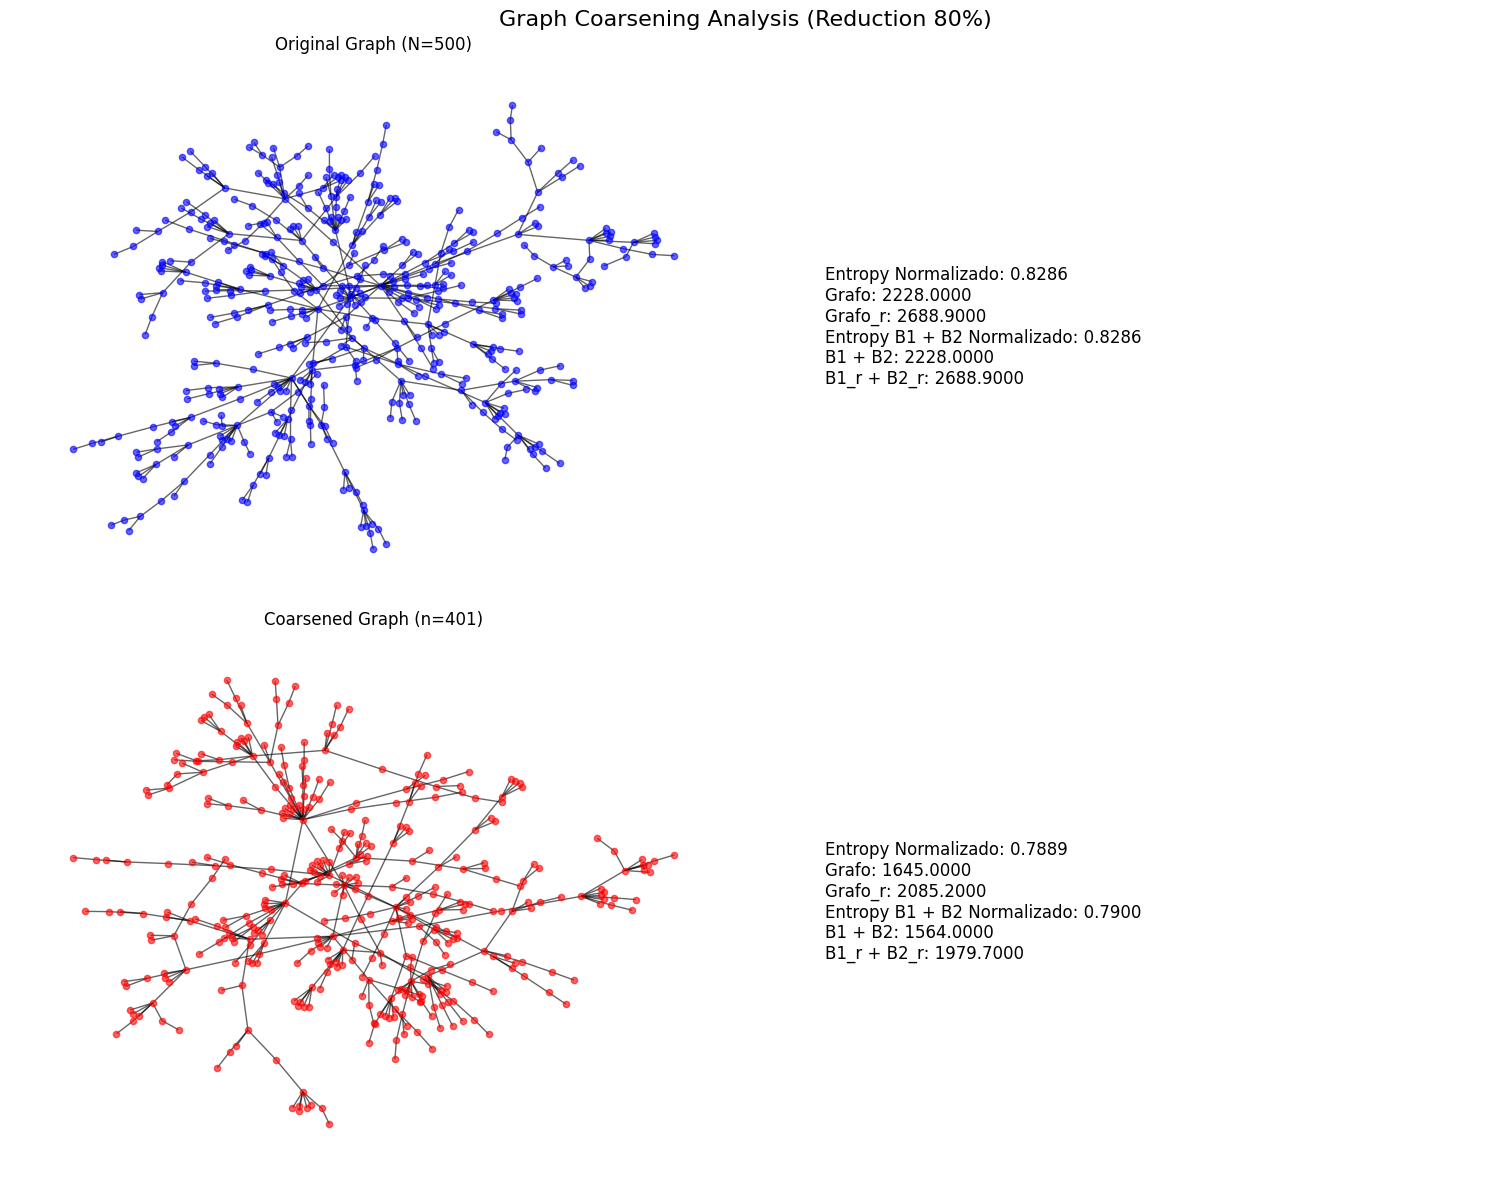

Generated 10 random graphs with ±1% error margin (499 target edges)
500
499
Using total compression length for all calculations
Entropia de grafo: 2228, Entropía B1 +B2 : 2228 y tamaño de la codificación: 37362
500
499
500
499
500
499
500
495
500
501
500
502
500
494
500
495
500
495
500
501
Entropia promedio de grafos random: 2671.70, Entropia B1+B2 promedio: 2671.70 y tamaño promedio de la codificación: 22185.10
Generated 10 random graphs with ±1% error margin (299 target edges)
300
299
Entropia de grafo: 1172, Entropía B1 +B2 : 1113 y tamaño de la codificación: 14091
300
297
300
296
300
297
300
299
300
296
300
297
300
297
300
299
300
299
300
297
Entropia promedio de grafos random: 1476.80, Entropia B1+B2 promedio: 1411.90 y tamaño promedio de la codificación: 8689.90


<Figure size 640x480 with 0 Axes>

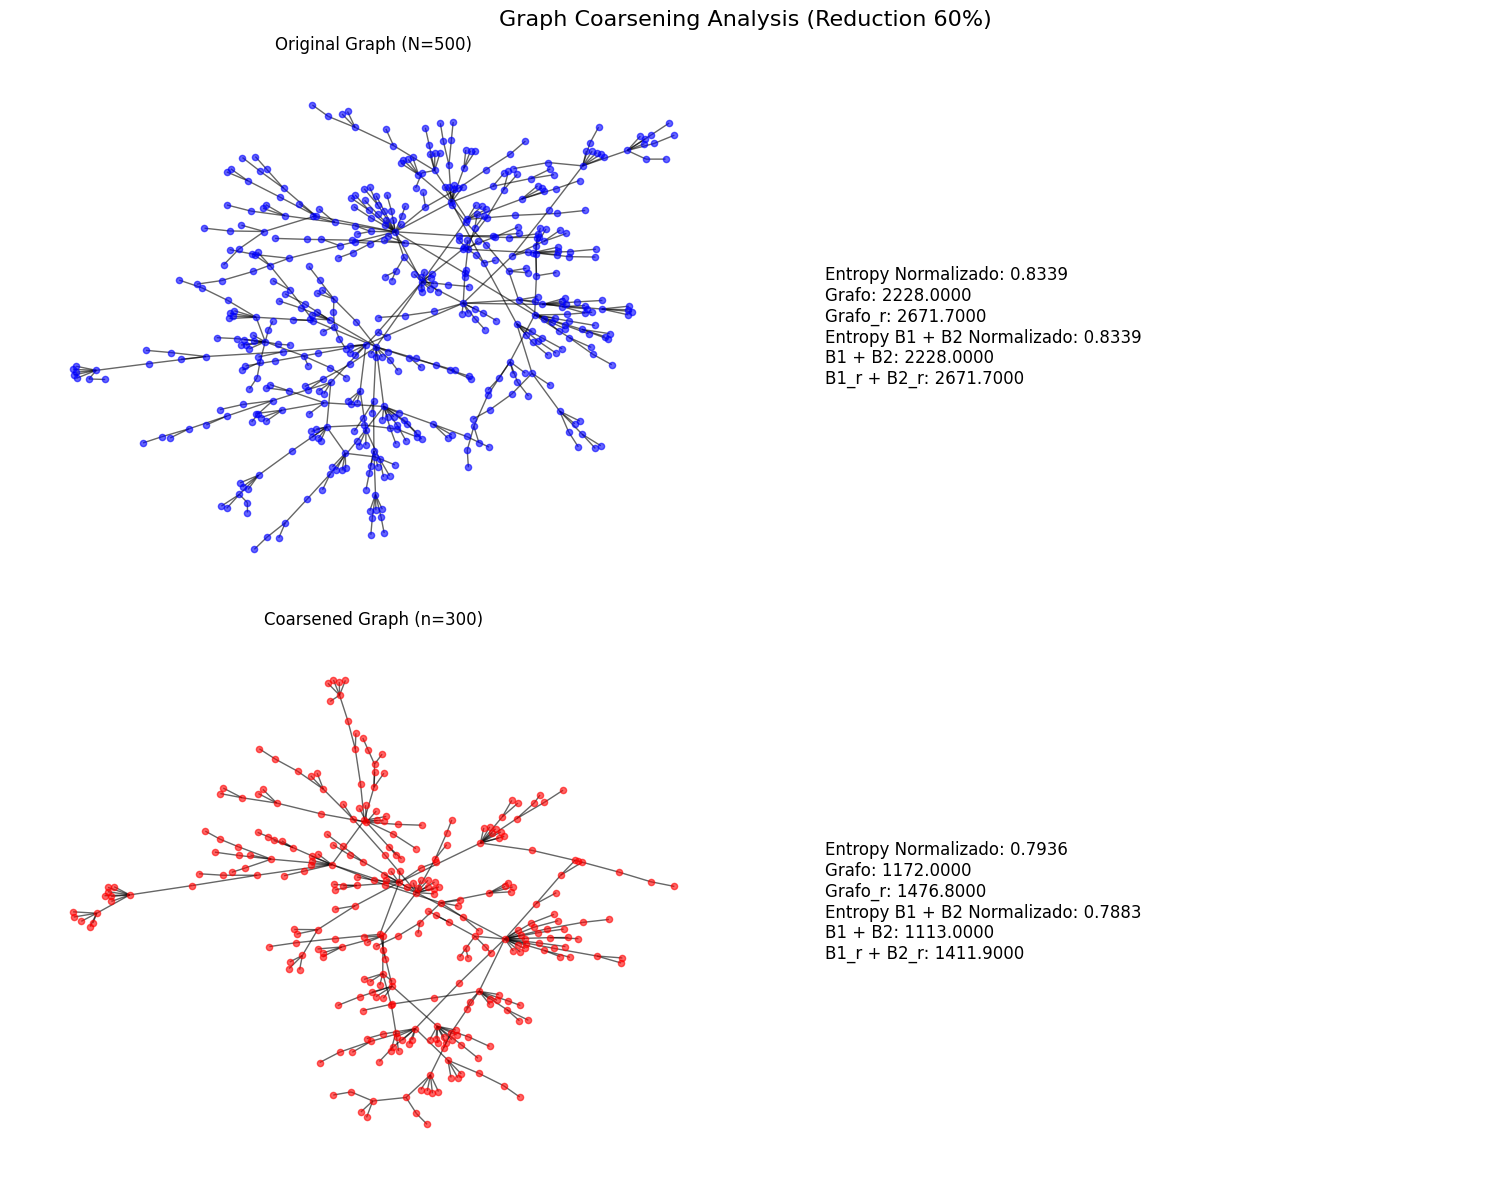

Generated 10 random graphs with ±1% error margin (499 target edges)
500
499
Using total compression length for all calculations
Entropia de grafo: 2228, Entropía B1 +B2 : 2228 y tamaño de la codificación: 37362
500
499
500
501
500
495
500
498
500
500
500
498
500
502
500
494
500
497
500
497
Entropia promedio de grafos random: 2698.70, Entropia B1+B2 promedio: 2698.70 y tamaño promedio de la codificación: 23149.90
Generated 10 random graphs with ±1% error margin (200 target edges)
201
200
Entropia de grafo: 848, Entropía B1 +B2 : 792 y tamaño de la codificación: 7086
201
199
201
202
201
199
201
202
201
198
201
199
201
198
201
201
201
200
201
201
Entropia promedio de grafos random: 920.20, Entropia B1+B2 promedio: 882.30 y tamaño promedio de la codificación: 4303.30


<Figure size 640x480 with 0 Axes>

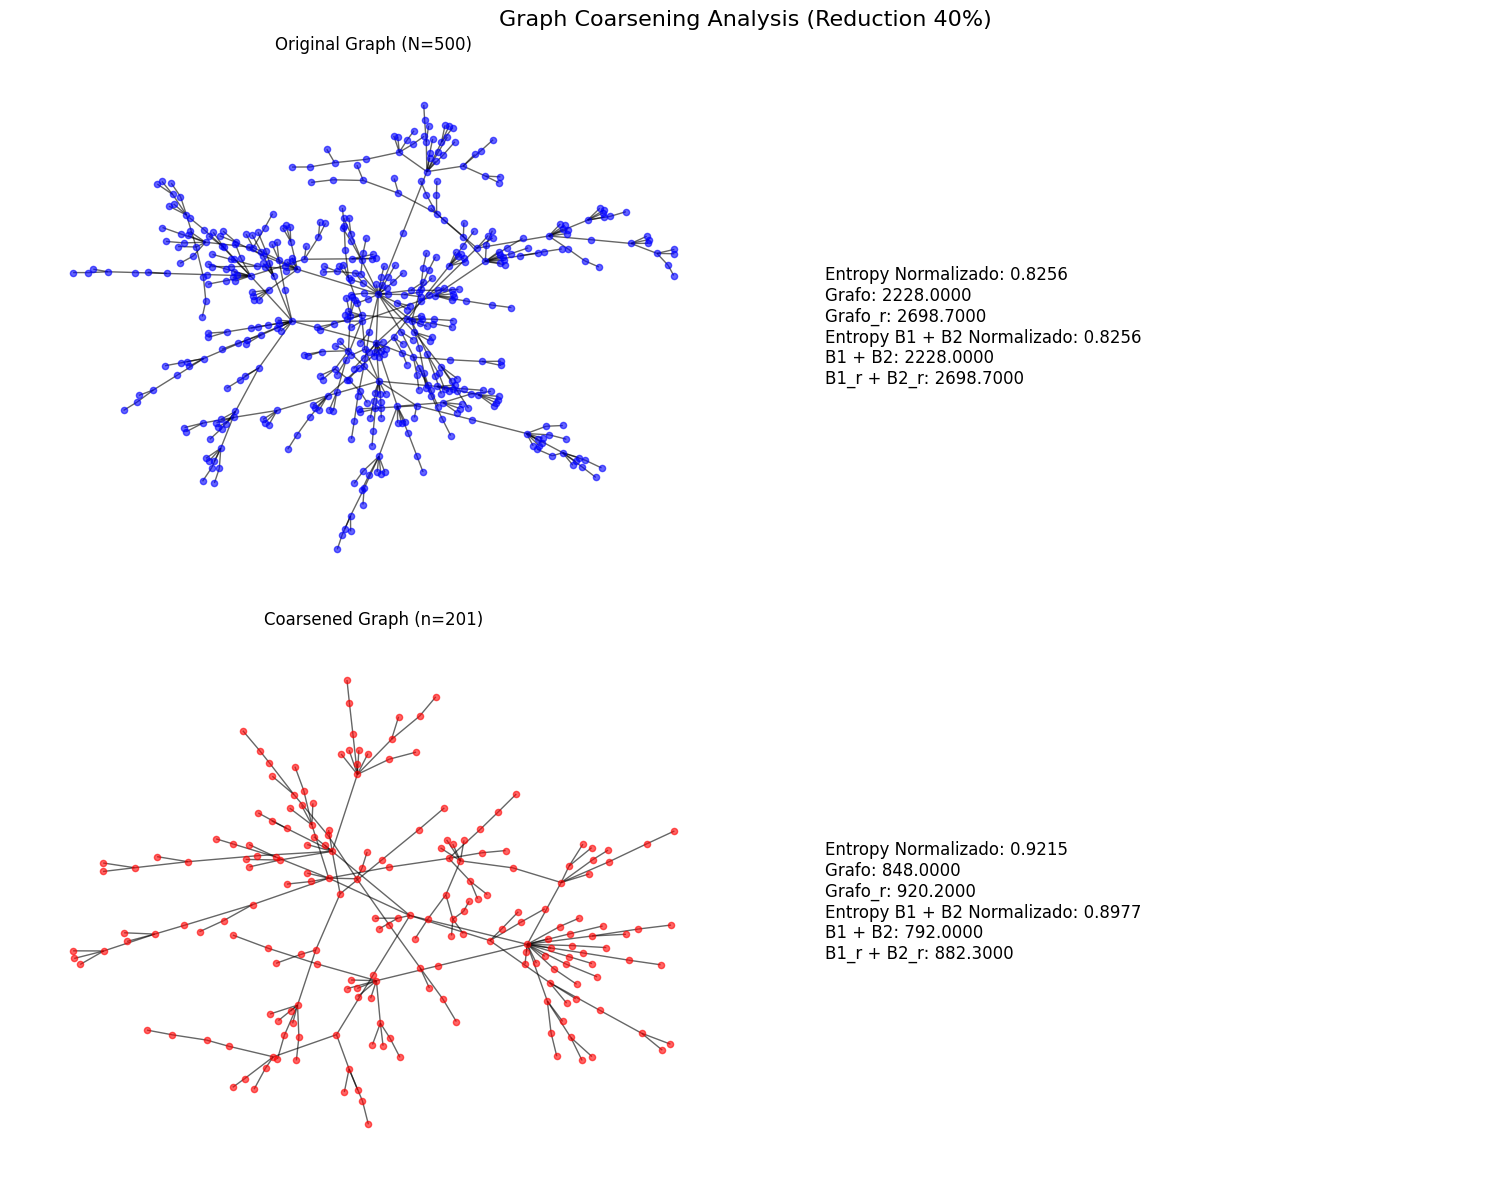

Generated 10 random graphs with ±1% error margin (499 target edges)
500
499
Using total compression length for all calculations
Entropia de grafo: 2228, Entropía B1 +B2 : 2228 y tamaño de la codificación: 37362
500
501
500
496
500
498
500
498
500
495
500
501
500
497
500
503
500
496
500
497
Entropia promedio de grafos random: 2682.70, Entropia B1+B2 promedio: 2682.70 y tamaño promedio de la codificación: 22033.60
Generated 7 random graphs with ±1% error margin (99 target edges)
100
99
Entropia de grafo: 381, Entropía B1 +B2 : 360 y tamaño de la codificación: 2074
100
98
100
99
100
99
100
99
100
98
100
98
100
99
Entropia promedio de grafos random: 396.29, Entropia B1+B2 promedio: 386.00 y tamaño promedio de la codificación: 1272.29


<Figure size 640x480 with 0 Axes>

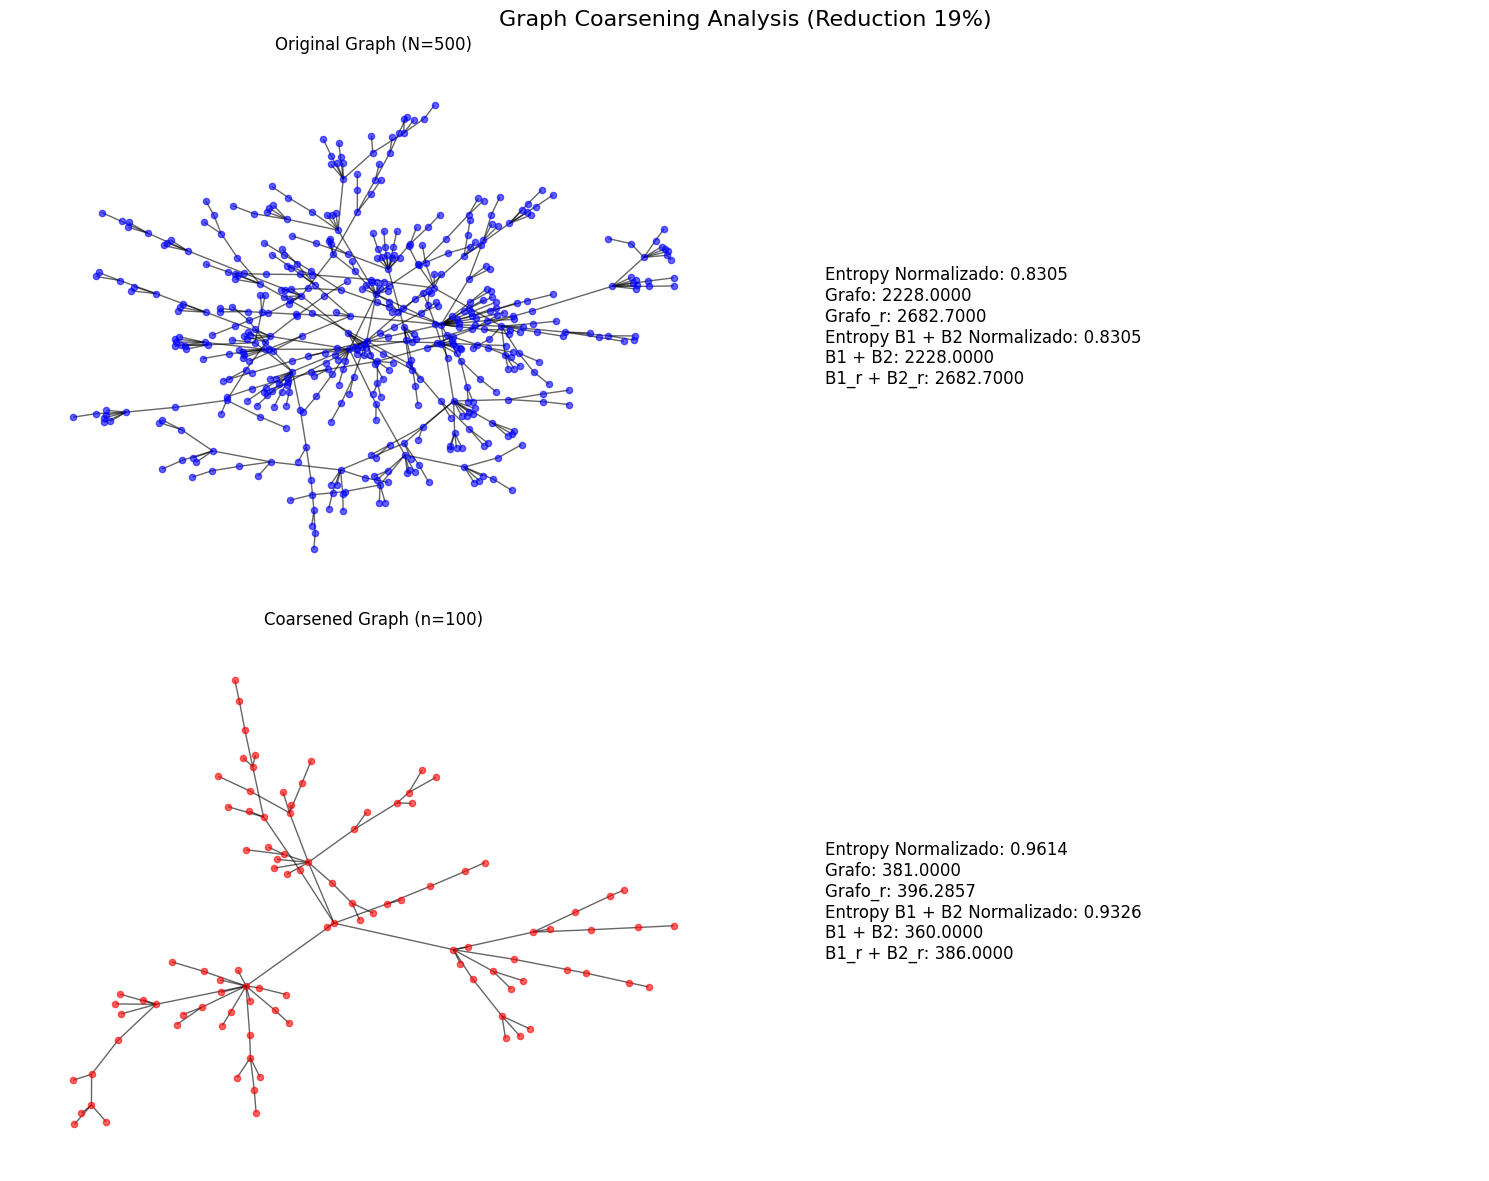

Plots have been saved in the 'coarsening_plots' directory.


In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

save_dir = 'coarsening_plots'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open('all_graphs.pkl', 'rb') as f:
    synthetic_graphs = pickle.load(f)

G = synthetic_graphs['barabasi'][500][0]

# Convert PyGSP to NetworkX properly
def pygsp_to_networkx(G):
    return nx.from_scipy_sparse_array(G.W)

# Define reduction ratios
reductions = [0.2, 0.4, 0.6, 0.8]  # To get 80, 60, 40, 20 nodes

for r in reductions:
    # Perform coarsening
    C, Gc, Call, Gall = coarsen(G, K=10, r=r, method="variation_neighborhoods")
    
    # Convert graphs to NetworkX
    G_nx = pygsp_to_networkx(G)
    Gc_nx = pygsp_to_networkx(Gc)
    
    # Clear any existing plots
    plt.clf()
    
    # Create figure with 2x2 subplots
    fig = plt.figure(figsize=(15, 12))
    
    # Plot original graph (a11)
    ax1 = fig.add_subplot(221)
    nx.draw(G_nx, node_size=20, node_color='b', alpha=0.6, 
            with_labels=False, pos=nx.spring_layout(G_nx))
    ax1.set_title(f"Original Graph (N={G.N})")
    
    # Plot entropy info (a12)
    ax2 = fig.add_subplot(222)
    ax2.axis('off')
    entropy_info = get_entropy_metadata_aritmethicEncoding(G_nx)
    info_text = "\n".join([f"{k}: {v:.4f}" for k, v in entropy_info.items()])
    ax2.text(0.1, 0.5, info_text, fontsize=12, verticalalignment='center')
    
    # Plot coarsened graph (a21)
    ax3 = fig.add_subplot(223)
    nx.draw(Gc_nx, node_size=20, node_color='r', alpha=0.6, 
            with_labels=False, pos=nx.spring_layout(Gc_nx))
    ax3.set_title(f"Coarsened Graph (n={Gc.N})")
    
    # Plot coarsened entropy info (a22)
    ax4 = fig.add_subplot(224)
    ax4.axis('off')
    entropy_info_c = get_entropy_metadata_aritmethicEncoding(Gc_nx)
    info_text = "\n".join([f"{k}: {v:.4f}" for k, v in entropy_info_c.items()])
    ax4.text(0.1, 0.5, info_text, fontsize=12, verticalalignment='center')
    
    plt.suptitle(f'Graph Coarsening Analysis (Reduction {int((1-r)*100)}%)', fontsize=16)
    plt.tight_layout()
    
    # Save the plot
    filename = os.path.join(save_dir, f'coarsening_analysis_{int((1-r)*100)}percent.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()
    
print(f"Plots have been saved in the '{save_dir}' directory.")

## Prueba grafos reales parte 2

In [36]:
import os
import numpy as np
from scipy import sparse
from pygsp import graphs
import pickle
from datetime import datetime

def read_as_graph(file_path):
    """Read AS graph and create PyGSP graph with coordinates"""
    # Read edges from file
    edges = []
    all_nodes = set()
    
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            try:
                source, target = map(int, line.strip().split())
                edges.append((source, target))
                all_nodes.add(source)
                all_nodes.add(target)
            except ValueError:
                continue
    
    # Create node mapping to ensure sequential indices
    node_list = sorted(all_nodes)
    node_map = {node: idx for idx, node in enumerate(node_list)}
    
    # Map edges to new indices
    mapped_edges = [(node_map[s], node_map[t]) for s, t in edges]
    
    # Create sparse adjacency matrix
    N = len(node_list)
    rows, cols = zip(*mapped_edges)
    data = np.ones(len(mapped_edges))
    
    # Create symmetric adjacency matrix
    W = sparse.coo_matrix((data, (rows, cols)), shape=(N, N))
    W = W + W.T  # Make it symmetric
    W.setdiag(0)  # Remove self-loops
    W = W.tocsr()
    
    # Create PyGSP graph
    G = graphs.Graph(W)
    
    # Compute coordinates (using random initialization for simplicity)
    np.random.seed(42)  # For reproducibility
    G.coords = np.random.rand(N, 2)  # Generate random 2D coordinates
    
    return G

# Get all AS files and sort them
as_folder = "as-733"
as_files = [f for f in os.listdir(as_folder) if f.startswith('as') and f.endswith('.txt')]
as_files.sort()

# Select 10 evenly spaced files
total_files = len(as_files)
indices = [int(i * (total_files - 1) / 24) for i in range(25)]
selected_files = [as_files[i] for i in indices]

# Dictionary to store the graphs
structured_graphs = {'as_networks': []}

# Process each selected file
for idx, file_name in enumerate(selected_files):
    print(f"Processing {file_name}")
    
    # Read and convert the graph
    file_path = os.path.join(as_folder, file_name)
    G = read_as_graph(file_path)
    
    # Add to list
    structured_graphs['as_networks'].append(G)
    
    print(f"Nodes: {G.N}, Edges: {G.W.nnz//2}")

# Save the graphs
with open('as_graphs.pkl', 'wb') as f:
    pickle.dump(structured_graphs, f)

# Print summary
print("\nGraph Information:")
print("AS NETWORKS:")
for idx, G in enumerate(structured_graphs['as_networks']):
    print(f"\nGraph {idx+1}:")
    print(f"Nodes: {G.N}")
    print(f"Edges: {G.W.nnz//2}")

Processing as19971108.txt


/home/sebabrzovic/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Nodes: 3015, Edges: 5156
Processing as19971208.txt
Nodes: 3141, Edges: 5581
Processing as19980108.txt
Nodes: 3244, Edges: 5668
Processing as19980208.txt
Nodes: 3335, Edges: 5937
Processing as19980311.txt
Nodes: 3444, Edges: 6102
Processing as19980411.txt
Nodes: 3576, Edges: 6403
Processing as19980513.txt
Nodes: 3645, Edges: 6629
Processing as19980614.txt
Nodes: 3727, Edges: 6775
Processing as19980720.txt
Nodes: 3836, Edges: 6932
Processing as19980819.txt
Nodes: 3970, Edges: 7004
Processing as19980920.txt
Nodes: 4120, Edges: 7585
Processing as19981020.txt
Nodes: 4206, Edges: 7551
Processing as19981120.txt
Nodes: 4341, Edges: 7949
Processing as19981220.txt
Nodes: 4424, Edges: 8175
Processing as19990122.txt
Nodes: 4542, Edges: 8452
Processing as19990222.txt
Nodes: 4689, Edges: 8763
Processing as19990325.txt
Nodes: 4841, Edges: 9107
Processing as19990426.txt
Nodes: 4974, Edges: 9503
Processing as19990528.txt
Nodes: 5162, Edges: 9856
Processing as19990628.txt
Nodes: 5322, Edges: 10163
Proce

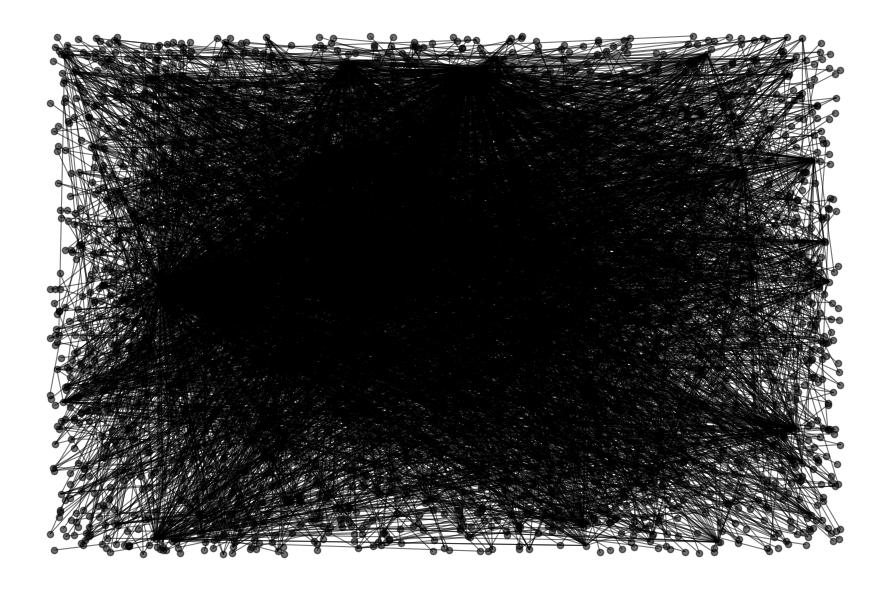

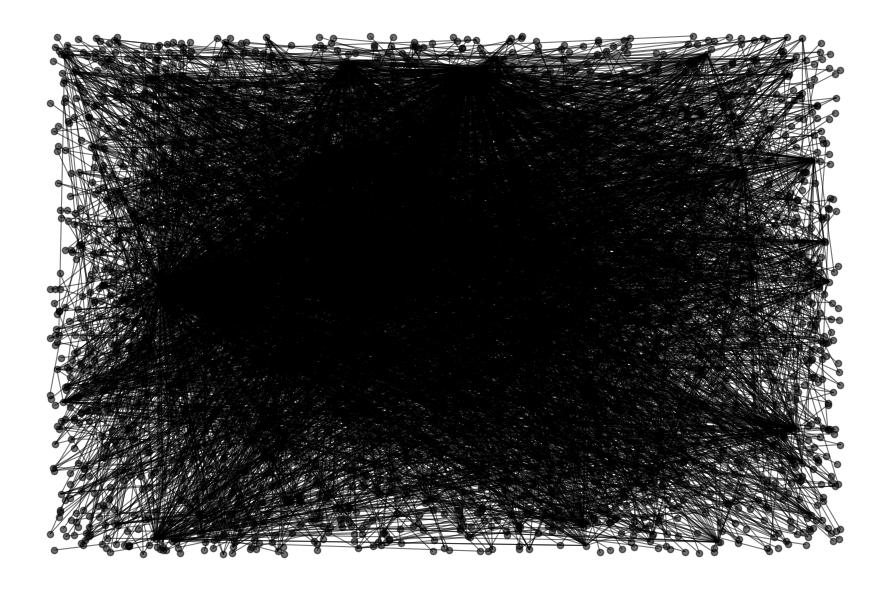

In [33]:
with open('as_graphs.pkl', 'rb') as f:
        as_graphs = pickle.load(f)
print(as_graphs['as_networks'][0])

cu.plot_graph(as_graphs['as_networks'][0])

In [37]:
import json
import numpy as np
from pygsp import graphs
import networkx as nx
import pickle

def get_graph_edges(graph):
    """Safely get number of edges from a PyGSP graph"""
    try:
        return int(graph.W.nnz / 2)  # Divide by 2 for undirected graphs
    except:
        return 0

def process_graphs(graphs_dict):
    """Process first n graphs from the dataset"""
    json_data = {}
    
    # Get first all graphs from as_networks
    graphs_to_process = graphs_dict['as_networks']
    
    for idx, graph in enumerate(graphs_to_process):
        print(f"\nProcessing graph {idx+1}")
        graph_name = f"as_network_{idx}"
        
        # Initialize reduction data
        reductions = {}
        current_graph = graph
        
        try:
            # Calculate initial metrics
            N = current_graph.N  # Original number of nodes
            E = get_graph_edges(current_graph)  # Original number of edges
            
            G_nx = nx.from_scipy_sparse_array(current_graph.W)
            entropy_metrics = get_entropy_metadata_aritmethicEncoding(G_nx)
            
            # Store original graph metrics (100%)
            reductions['100'] = {
                'number_nodes': N,
                'number_edges': E,
                'ave_degree': 2 * E / N if N > 0 else 0,
                'entropy_arithmetic': entropy_metrics
            }
            
            # Perform reductions
            for reduction in [80, 60, 40, 20]:
                try:
                    # Calculate reduction ratio
                    r = 1 - (reduction/100)
                    print(f"Processing {reduction}% reduction...")
                    
                    # Perform coarsening
                    C, Gc, Call, Gall = coarsen(current_graph, K=10, r=r)
                    
                    if Gc is not None:
                        n = Gc.N  # Number of nodes after reduction
                        e = get_graph_edges(Gc)  # Number of edges after reduction
                        
                        reductions[str(reduction)] = {
                            'number_nodes': n,
                            'number_edges': e,
                            'ave_degree': 2 * e / n if n > 0 else 0,
                        }
                        
                        #Calculate entropy metrics if needed
                        #(commented out for now to verify basic functionality)
                        G_nx = nx.from_scipy_sparse_array(Gc.W)
                        entropy_metrics = get_entropy_metadata_aritmethicEncoding(G_nx)
                        reductions[str(reduction)]['entropy_arithmetic'] = entropy_metrics
                        
                except Exception as e:
                    print(f"Error in reduction {reduction}%: {str(e)}")
                    continue
            
            # Add to json data
            json_data[graph_name] = {
                'Name': graph_name,
                'Subdomain': 'AS Networks',
                'Node_Type': 'AS',
                'Edge_Type': 'Connection',
                'reductions': reductions
            }
            
        except Exception as e:
            print(f"Error processing graph {graph_name}: {str(e)}")
            continue
    
    return json_data

# Load the graphs
with open('as_graphs.pkl', 'rb') as f:
    graphs_dict = pickle.load(f)

# Process first 2 graphs
json_data = process_graphs(graphs_dict)

# Save results
with open('as_graphs_analysis.json', 'w') as f:
    json.dump(json_data, f, indent=2)

# Print summary of results
for graph_name, data in json_data.items():
    print(f"\nResults for {graph_name}:")
    for reduction, metrics in data['reductions'].items():
        print(f"\n{reduction}% of original graph:")
        print(f"Nodes: {metrics['number_nodes']}")
        print(f"Edges: {metrics['number_edges']}")
        print(f"Average degree: {metrics['ave_degree']:.2f}")


Processing graph 1
Generated 10 random graphs with ±1% error margin (5156 target edges)
3015
5156
Entropia de grafo: 22754, Entropía B1 +B2 : 22608 y tamaño de la codificación: 1553916
3015
5119
3015
5128
3015
5156
3015
5153
3015
5192
3015
5155
3015
5156
3015
5118
3015
5141
3015
5190
Entropia promedio de grafos random: 41496.60, Entropia B1+B2 promedio: 40372.50 y tamaño promedio de la codificación: 1884863.10
Processing 80% reduction...
Generated 10 random graphs with ±1% error margin (4396 target edges)
2413
4396
Entropia de grafo: 17673, Entropía B1 +B2 : 17654 y tamaño de la codificación: 922326
2413
4357
2413
4432
2413
4377
2413
4357
2413
4371
2413
4403
2413
4438
2413
4427
2413
4438
2413
4378
Entropia promedio de grafos random: 34567.50, Entropia B1+B2 promedio: 33709.80 y tamaño promedio de la codificación: 1297915.50
Processing 60% reduction...
Generated 10 random graphs with ±1% error margin (3467 target edges)
1809
3467
Entropia de grafo: 15125, Entropía B1 +B2 : 15118 y tama

Distribution Analysis of Original Graphs:

Node Distribution:
Min nodes: 3015
Max nodes: 6474
Mean nodes: 4354.80
Median nodes: 4206.00
Std nodes: 969.12

Node Quantiles:
0%: 3015.00
20%: 3422.20
40%: 3916.40
60%: 4471.20
80%: 5194.00
100%: 6474.00

Edge Distribution:
Min edges: 5156
Max edges: 12572
Mean edges: 8091.08
Median edges: 7585.00
Std edges: 2069.46

Edge Quantiles:
0%: 5156.00
20%: 6266.80
40%: 6975.20
60%: 8285.80
80%: 9917.40
100%: 12572.00


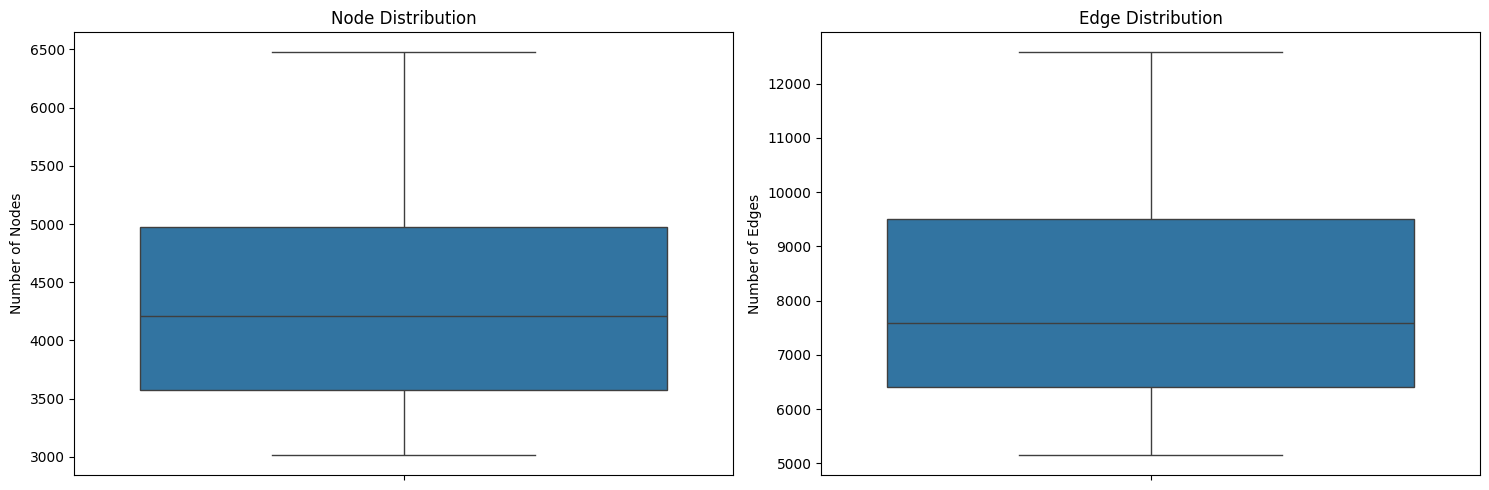

In [39]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_original_graphs(json_file):
    """Analyze node and edge distributions of original graphs with quantiles"""
    # Load JSON data
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Extract nodes and edges from original graphs
    nodes = []
    edges = []
    
    for graph_name, graph_data in data.items():
        graph_100 = graph_data['reductions']['100']
        nodes.append(graph_100['number_nodes'])
        edges.append(graph_100['number_edges'])
    
    # Convert to numpy arrays
    nodes = np.array(nodes)
    edges = np.array(edges)
    
    # Calculate quantiles (0%, 20%, 40%, 60%, 80%, 100%)
    quantiles = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    node_quantiles = np.quantile(nodes, quantiles)
    edge_quantiles = np.quantile(edges, quantiles)
    
    # Calculate basic statistics
    stats = {
        'Nodes': {
            'min': np.min(nodes),
            'max': np.max(nodes),
            'mean': np.mean(nodes),
            'median': np.median(nodes),
            'std': np.std(nodes),
            'quantiles': dict(zip(['0%', '20%', '40%', '60%', '80%', '100%'], node_quantiles))
        },
        'Edges': {
            'min': np.min(edges),
            'max': np.max(edges),
            'mean': np.mean(edges),
            'median': np.median(edges),
            'std': np.std(edges),
            'quantiles': dict(zip(['0%', '20%', '40%', '60%', '80%', '100%'], edge_quantiles))
        }
    }
    
    # Print results
    print("Distribution Analysis of Original Graphs:")
    print("\nNode Distribution:")
    print(f"Min nodes: {stats['Nodes']['min']}")
    print(f"Max nodes: {stats['Nodes']['max']}")
    print(f"Mean nodes: {stats['Nodes']['mean']:.2f}")
    print(f"Median nodes: {stats['Nodes']['median']:.2f}")
    print(f"Std nodes: {stats['Nodes']['std']:.2f}")
    print("\nNode Quantiles:")
    for q, v in stats['Nodes']['quantiles'].items():
        print(f"{q}: {v:.2f}")
    
    print("\nEdge Distribution:")
    print(f"Min edges: {stats['Edges']['min']}")
    print(f"Max edges: {stats['Edges']['max']}")
    print(f"Mean edges: {stats['Edges']['mean']:.2f}")
    print(f"Median edges: {stats['Edges']['median']:.2f}")
    print(f"Std edges: {stats['Edges']['std']:.2f}")
    print("\nEdge Quantiles:")
    for q, v in stats['Edges']['quantiles'].items():
        print(f"{q}: {v:.2f}")
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Node distribution
    sns.boxplot(y=nodes, ax=ax1)
    ax1.set_title('Node Distribution')
    ax1.set_ylabel('Number of Nodes')
    
    # Edge distribution
    sns.boxplot(y=edges, ax=ax2)
    ax2.set_title('Edge Distribution')
    ax2.set_ylabel('Number of Edges')
    
    plt.tight_layout()
    plt.show()
    
    return stats

# Use the function
stats = analyze_original_graphs('as_graphs_analysis.json')

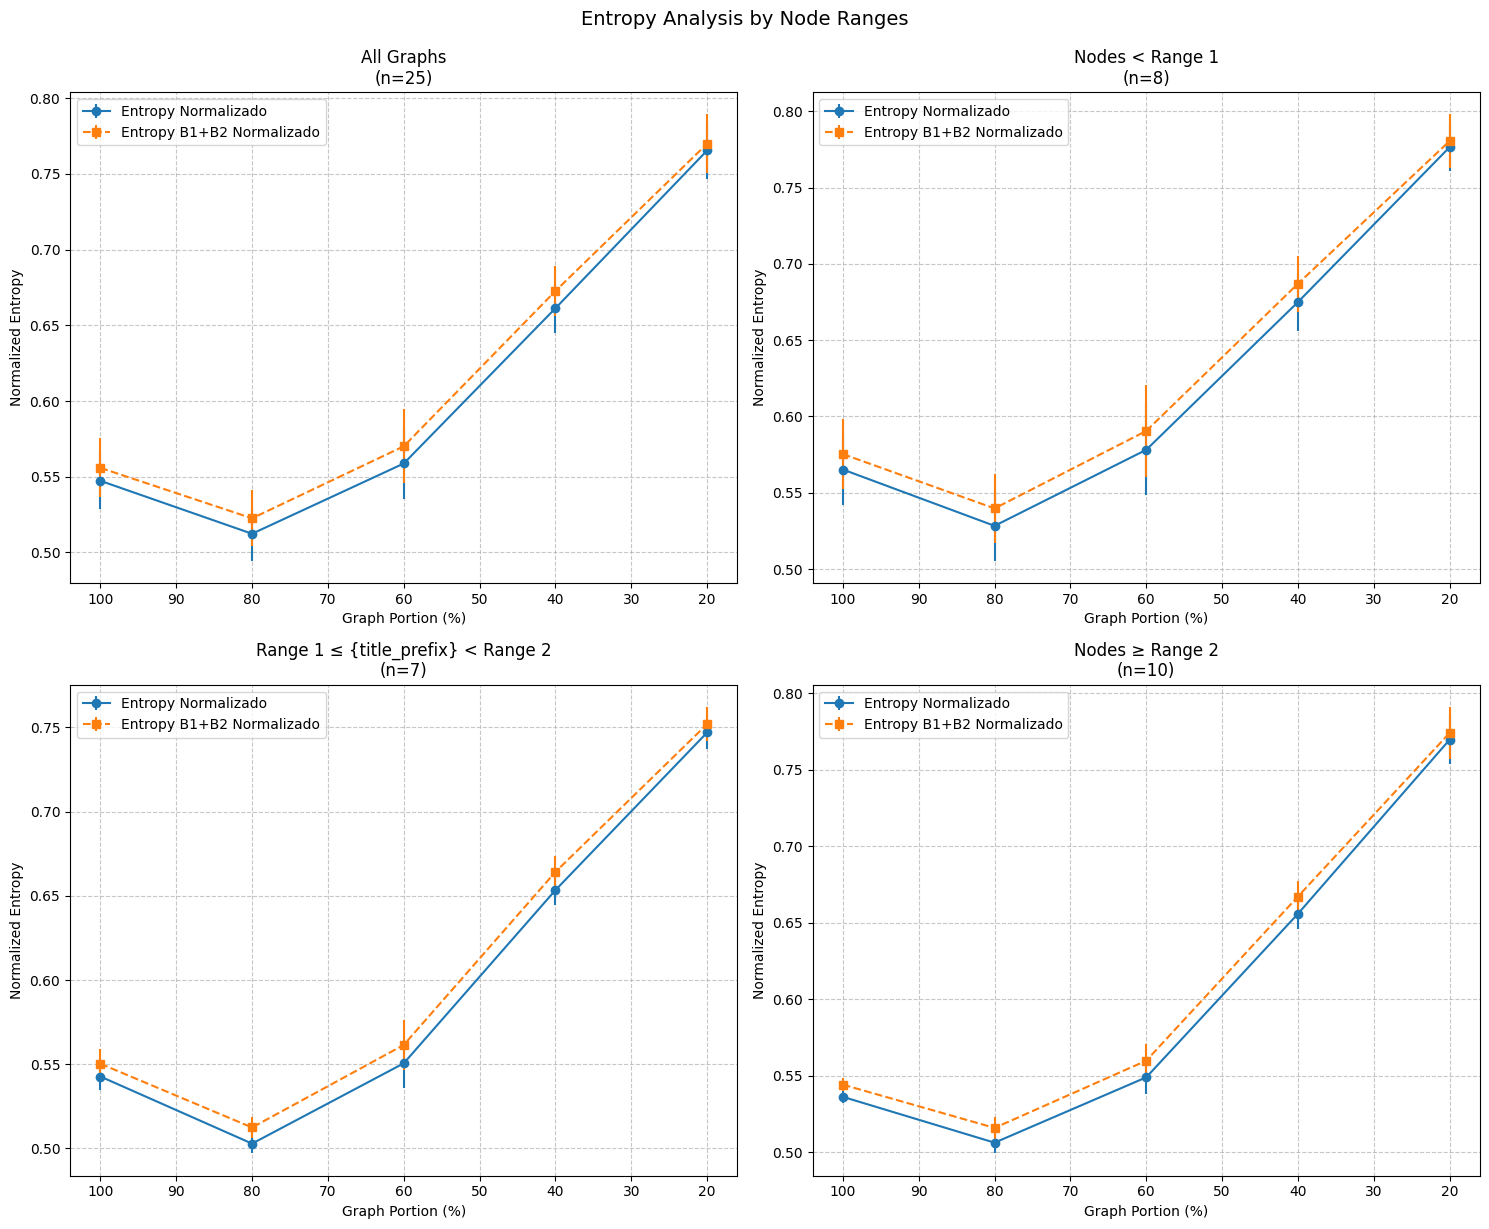

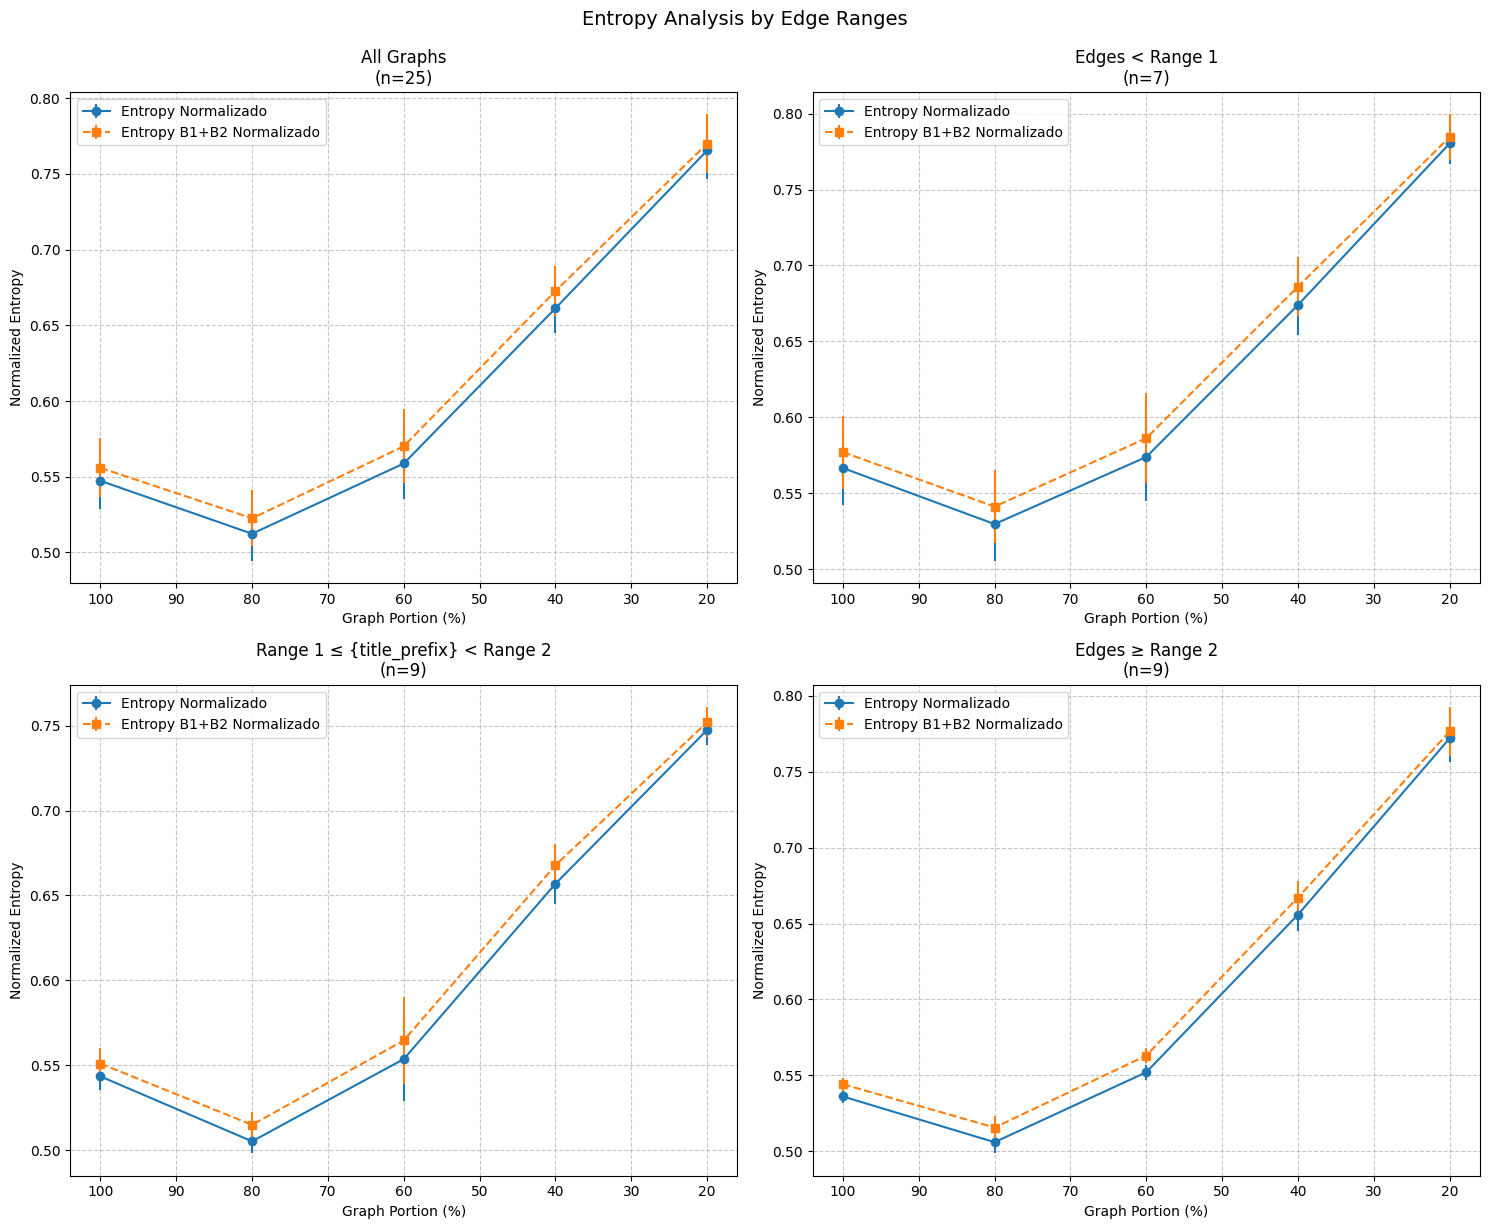

In [42]:
def plot_entropy_analysis(json_file):
    # Load JSON data
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Prepare data structures
    reduction_levels = ['100', '80', '60', '40', '20']
    
    # Extract data and organize by node ranges
    node_ranges = {
        'all': [],
        'small': [],    # <3700
        'medium': [],   # 3700-4500
        'large': []     # >4500
    }
    
    edge_ranges = {
        'all': [],
        'small': [],    # <6500
        'medium': [],   # 6500-8500
        'large': []     # >8500
    }
    
    # Process each graph
    for graph_name, graph_data in data.items():
        graph_info = []
        nodes = graph_data['reductions']['100']['number_nodes']
        edges = graph_data['reductions']['100']['number_edges']
        
        # Extract entropy values for each reduction level
        for level in reduction_levels:
            metrics = graph_data['reductions'][level]['entropy_arithmetic']
            graph_info.append([
                metrics['Entropy Normalizado'],
                metrics['Entropy B1 + B2 Normalizado']
            ])
        
        # Add to appropriate ranges
        node_ranges['all'].append(graph_info)
        if nodes < 3700:
            node_ranges['small'].append(graph_info)
        elif nodes < 4500:
            node_ranges['medium'].append(graph_info)
        else:
            node_ranges['large'].append(graph_info)
            
        edge_ranges['all'].append(graph_info)
        if edges < 6500:
            edge_ranges['small'].append(graph_info)
        elif edges < 8500:
            edge_ranges['medium'].append(graph_info)
        else:
            edge_ranges['large'].append(graph_info)
    
    # Create plots
    def create_figure(ranges, title_prefix):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        titles = ['All Graphs', f'{title_prefix} < Range 1', 'Range 1 ≤ {title_prefix} < Range 2', f'{title_prefix} ≥ Range 2']
        ranges_keys = ['all', 'small', 'medium', 'large']
        
        for ax, title, range_key in zip(axes, titles, ranges_keys):
            if len(ranges[range_key]) > 0:
                data_array = np.array(ranges[range_key])
                
                # Calculate means for both entropy types
                means_entropy = np.mean(data_array[:, :, 0], axis=0)
                means_entropy_b1b2 = np.mean(data_array[:, :, 1], axis=0)
                
                # Calculate standard deviations
                std_entropy = np.std(data_array[:, :, 0], axis=0)
                std_entropy_b1b2 = np.std(data_array[:, :, 1], axis=0)
                
                # Plot with error bars
                x = np.array([100, 80, 60, 40, 20])
                ax.errorbar(x, means_entropy, yerr=std_entropy, 
                          label='Entropy Normalizado', linestyle='-', marker='o')
                ax.errorbar(x, means_entropy_b1b2, yerr=std_entropy_b1b2, 
                          label='Entropy B1+B2 Normalizado', linestyle='--', marker='s')
            
            ax.set_xlabel('Graph Portion (%)')
            ax.set_ylabel('Normalized Entropy')
            ax.set_title(title)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend()
            #revert the x axis
            ax.invert_xaxis()
            
            # Add number of graphs in the title
            n_graphs = len(ranges[range_key])
            ax.set_title(f"{title}\n(n={n_graphs})")
        
        plt.tight_layout()
        return fig
    
    # Create and save both figures
    fig_nodes = create_figure(node_ranges, 'Nodes')
    fig_nodes.suptitle('Entropy Analysis by Node Ranges', y=1.02, fontsize=14)
    plt.savefig('entropy_by_nodes.png', bbox_inches='tight', dpi=300)
    
    fig_edges = create_figure(edge_ranges, 'Edges')
    fig_edges.suptitle('Entropy Analysis by Edge Ranges', y=1.02, fontsize=14)
    plt.savefig('entropy_by_edges.png', bbox_inches='tight', dpi=300)
    
    plt.show()

# Use the function
plot_entropy_analysis('as_graphs_analysis.json')

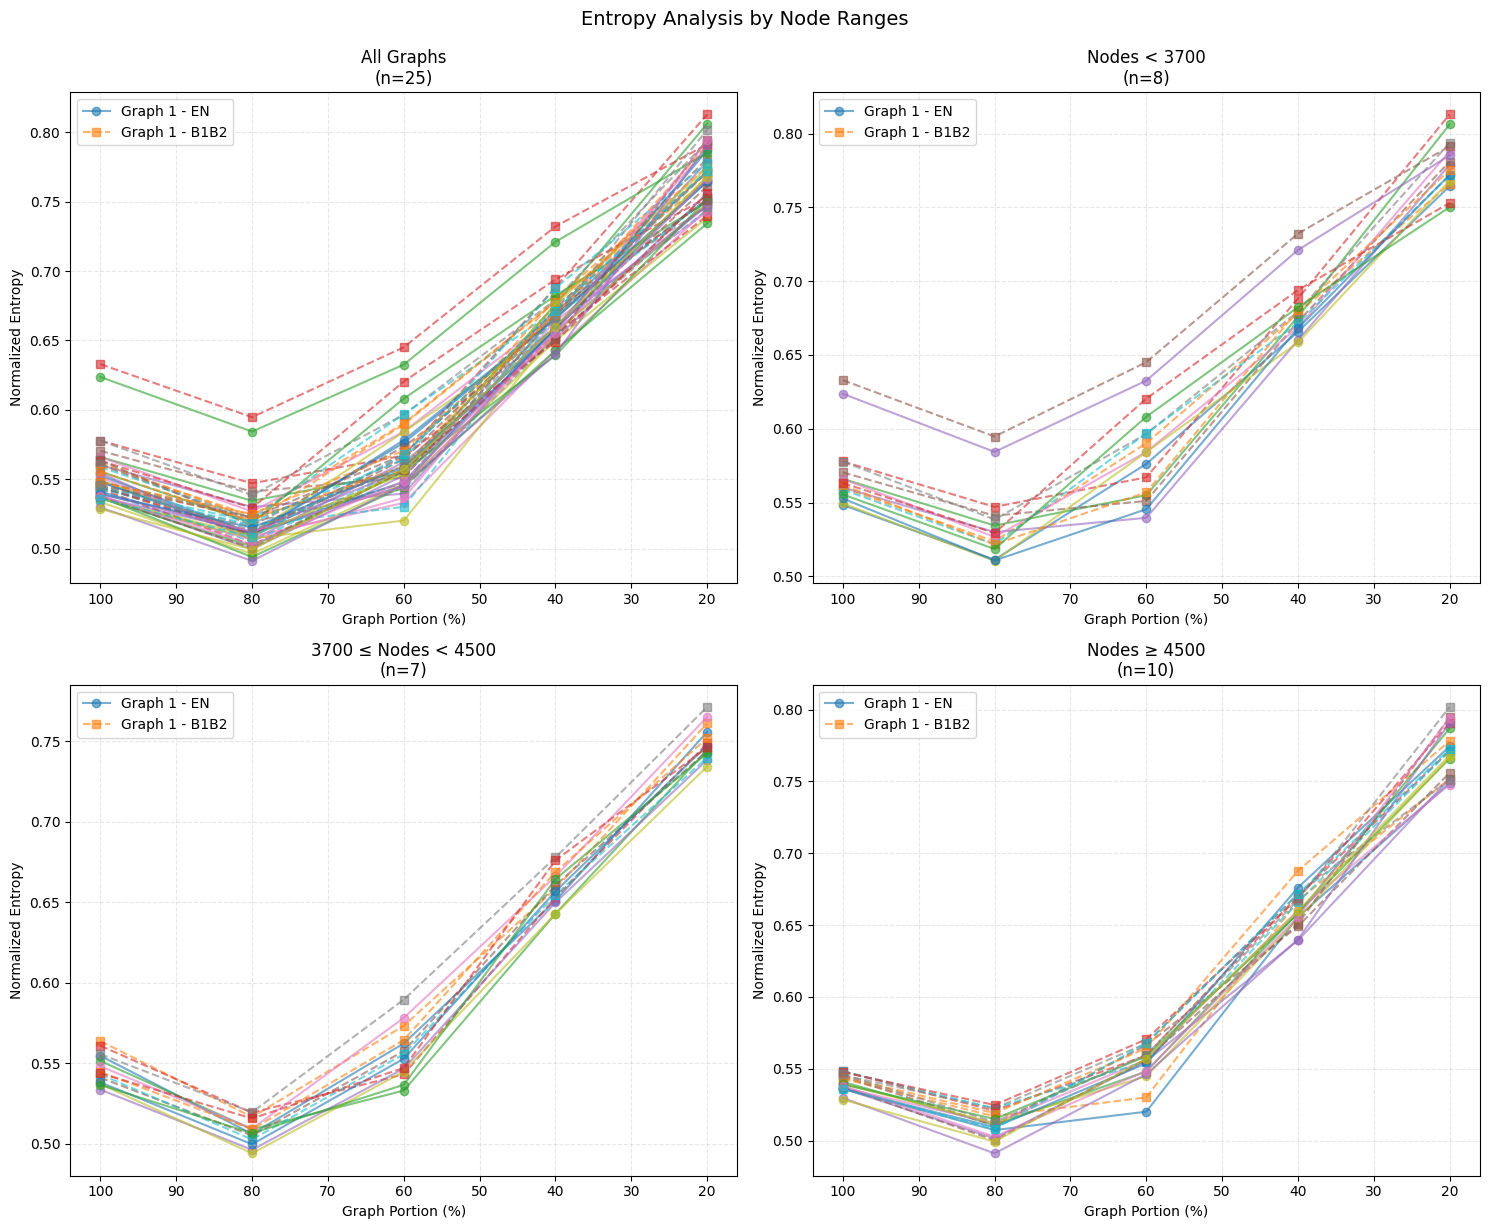

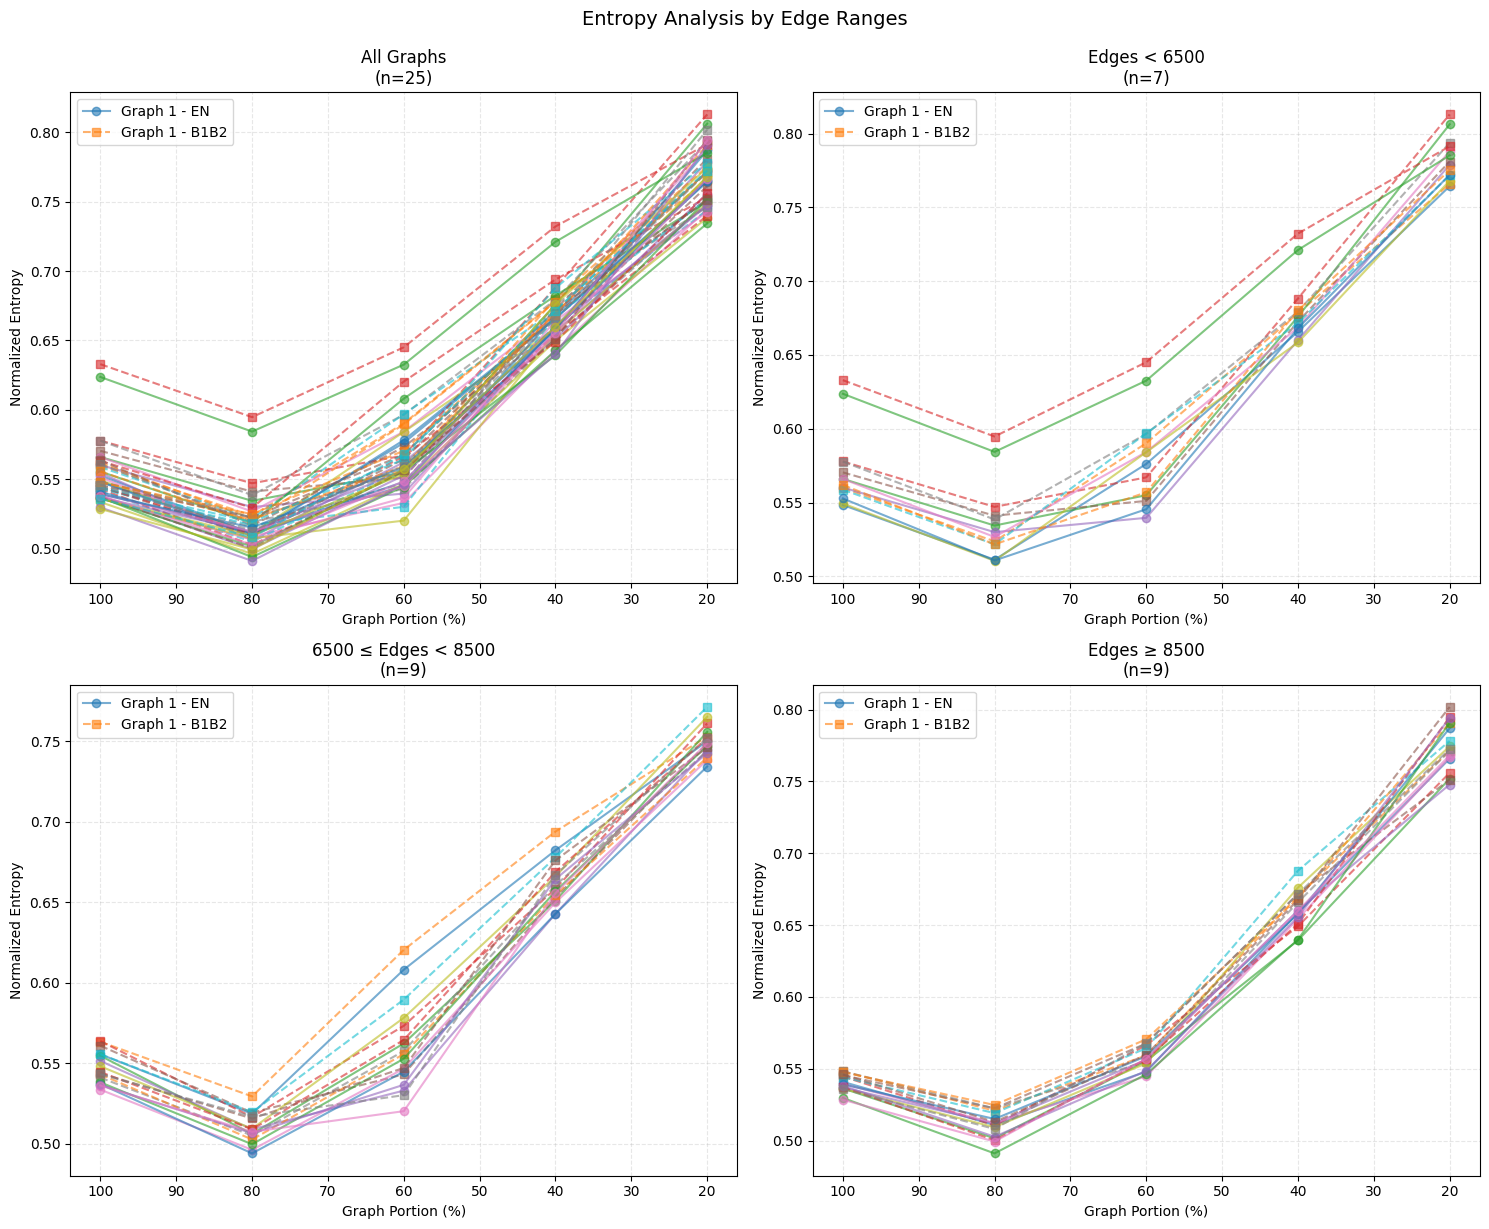

In [44]:
def plot_entropy_analysis(json_file):
    # Load JSON data
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    reduction_levels = ['100', '80', '60', '40', '20']
    x_values = [100, 80, 60, 40, 20]
    
    def create_figure(graphs_by_range, title_prefix):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
        
        ranges = ['all', 'small', 'medium', 'large']
        
        # Define proper range titles
        if title_prefix == 'Nodes':
            titles = ['All Graphs', 'Nodes < 3700', 
                     '3700 ≤ Nodes < 4500', 'Nodes ≥ 4500']
        else:  # Edges
            titles = ['All Graphs', 'Edges < 6500', 
                     '6500 ≤ Edges < 8500', 'Edges ≥ 8500']
        
        for ax, range_key, title in zip(axes, ranges, titles):
            if range_key == 'all':
                graphs = graphs_by_range['all']
            elif range_key == 'small':
                graphs = graphs_by_range['small']
            elif range_key == 'medium':
                graphs = graphs_by_range['medium']
            else:
                graphs = graphs_by_range['large']
            
            if graphs:
                # Plot individual lines for each graph
                for i, graph_data in enumerate(graphs):
                    entropy_norm = [d[0] for d in graph_data]
                    entropy_b1b2 = [d[1] for d in graph_data]
                    
                    ax.plot(x_values, entropy_norm, '-o', alpha=0.6, 
                           label=f'Graph {i+1} - EN' if i == 0 else None)
                    ax.plot(x_values, entropy_b1b2, '--s', alpha=0.6, 
                           label=f'Graph {i+1} - B1B2' if i == 0 else None)
            
            ax.set_xlabel('Graph Portion (%)')
            ax.set_ylabel('Normalized Entropy')
            ax.grid(True, linestyle='--', alpha=0.3)
            if graphs:
                ax.legend()
            ax.invert_xaxis()
            ax.set_title(f"{title}\n(n={len(graphs)})")
        
        plt.tight_layout()
        return fig
    
    # Organize graphs by ranges
    node_ranges = {'all': [], 'small': [], 'medium': [], 'large': []}
    edge_ranges = {'all': [], 'small': [], 'medium': [], 'large': []}
    
    for graph_name, graph_data in data.items():
        graph_info = []
        nodes = graph_data['reductions']['100']['number_nodes']
        edges = graph_data['reductions']['100']['number_edges']
        
        for level in reduction_levels:
            metrics = graph_data['reductions'][level]['entropy_arithmetic']
            graph_info.append([
                metrics['Entropy Normalizado'],
                metrics['Entropy B1 + B2 Normalizado']
            ])
        
        node_ranges['all'].append(graph_info)
        if nodes < 3700:
            node_ranges['small'].append(graph_info)
        elif nodes < 4500:
            node_ranges['medium'].append(graph_info)
        else:
            node_ranges['large'].append(graph_info)
            
        edge_ranges['all'].append(graph_info)
        if edges < 6500:
            edge_ranges['small'].append(graph_info)
        elif edges < 8500:
            edge_ranges['medium'].append(graph_info)
        else:
            edge_ranges['large'].append(graph_info)
    
    # Create and save figures
    fig_nodes = create_figure(node_ranges, 'Nodes')
    fig_nodes.suptitle('Entropy Analysis by Node Ranges', y=1.02, fontsize=14)
    plt.savefig('entropy_by_nodes.png', bbox_inches='tight', dpi=300)
    
    fig_edges = create_figure(edge_ranges, 'Edges')
    fig_edges.suptitle('Entropy Analysis by Edge Ranges', y=1.02, fontsize=14)
    plt.savefig('entropy_by_edges.png', bbox_inches='tight', dpi=300)
    
    plt.show()

# Use the function
plot_entropy_analysis('as_graphs_analysis.json')